# IEEE-CIS Fraud Detection — Data Dictionary & EDA Playbook (Step 1)

## Tables & Join
- **Tables**: train_transaction / test_transaction and train_identity / test_identity
- **Join key**: TransactionID (left join transaction ↔ identity)
- **Coverage**: Identity coverage is partial. Action: measure the join hit-rate over time and across key entities (e.g., card1) and treat identity missingness as a potential signal

---

## Transaction Table

### A) Keys & Target
- **TransactionID** — row key; used to join with identity
- **isFraud** — binary target (train only)

### B) Core Timing & Amount
- **TransactionDT** — relative timestamp (seconds from an unknown anchor; not a real datetime)
  - Create hour/day/week features from this relative axis (e.g., hours = TransactionDT / 3600)
  - Define t0 = min(TransactionDT) for calendar-like derivations; never mix with real calendars
  - **Critical**: Use for chronological (past→future) splits to prevent leakage
  - Note: TransactionDT spans several months, so weekly/monthly patterns are discoverable
- **TransactionAmt** — payment amount (USD; some converted)
  - Useful for log scaling/binning and analyzing micro vs. high-value fraud patterns

### C) Product / Payment Instrument
- **ProductCD** — product category code for the transaction
- **card1–card6** — payment card attributes (issuer/bank/type/network/category/country; semantics masked)
  - Expect a mix of high-cardinality IDs and low-cardinality categories

### D) Location / Contact Proxies
- **addr1, addr2** — billing-region / country-level signals (masked)
- **dist1, dist2** — anonymous "distance"-style risk signals; typically sparse and skewed
  - Plan for winsorizing/robust scaling and explicit missingness flags
- **P_emaildomain, R_emaildomain** — purchaser and recipient email domains
  - Good for free-mail vs corporate buckets, rare-domain flags, and normalization

### E) Behavioral Aggregates (Engineered by Data Provider)
- **C1–C14** — "counting" features (profile intensity across entities like card/address/device; masked)
- **D1–D15** — time-delta features (e.g., recency since prior events)
  - Often powerful; correlate with time. Monitor for leakage risk
- **M1–M9** — "match"/consistency flags (binary/categorical)
- **V1–V339** — rich engineered signals (ranks/counts/relations; masked)
  - Treat as black-box features; scrutinize with permutation importance and time-aware validation

---

## Identity Table

### F) Device & Environment
- **DeviceType** — device class (desktop/mobile)
- **DeviceInfo** — device brand/model string (messy; normalize)
- **Readable IDs**:
  - **id_30** — operating system string (e.g., "Windows 10", "iOS 13")
  - **id_31** — browser / UA family (e.g., "chrome", "safari")
  - **id_33** — screen resolution ("widthxheight")

### G) Network / Risk Signals & Flags (Mostly Anonymized)
- **id_01–id_38** — numeric/categorical risk signals tied to network (IP/ISP/proxy) and digital signature (UA/OS/browser versions), plus various boolean-like flags (e.g., id_35–id_38)
- **Use**: footprint stability/consistency checks; normalize strings and unify flag encodings

---

## H) Critical Data-Leakage Considerations (Read Me!)
- **Time-aware splits**: Always split chronologically using TransactionDT. Train on past, validate on future
- **Past-only transforms**: Any encoding/aggregation (target/frequency/group-stats) must be fit only on training windows
- **No global peeking**: Don't compute "global" means/frequencies using data from the future fold
- **Identity coverage**: Quantify coverage by time/entity; missingness patterns can be predictive
- **Feature windows**: For "days since last X," ensure the reference event strictly precedes the row within the training window

---

## Logical Groupings for EDA Workflow

### 1. Keys & Target
- TransactionID, isFraud, join coverage vs identity over time/cohorts

### 2. Time & Amount
- TransactionDT, TransactionAmt → drift, seasonality, tails, micro vs high-value bands

### 3. Product & Instrument
- ProductCD, card1–card6 → cardinality, long-tail %, per-level fraud rates, temporal stability

### 4. Geo/Contact Proxies
- addr1/addr2, dist1/2, P_emaildomain, R_emaildomain → normalization, rarity, outliers, missingness

### 5. Behavioral Aggregates
- C*, D*, M*, V* → distributions, missingness heatmaps, family-level importance, leakage risk (esp. D*/V*)

### 6. Device & Identity Footprint
- DeviceType, DeviceInfo, id_30, id_31, id_33, others id_* → normalization, stability, identity hit-rate

---

## I) Practical Feature Blocks You'll Derive (for EDA + Models)

### Missingness Signatures
- **na_ct_C, na_ct_D, na_ct_M, na_ct_V, na_ct_id** (counts per family)
- **na_ratio_*** counterparts; plus global na_ct_all, na_ratio_all
- **Why**: Missingness patterns are often robust signals in fraud

### Rarity & Burstiness
- For high-card features (card1, P_emaildomain, DeviceInfo, etc.), compute frequency buckets (rare/occasional/common) and is_rare_* flags
- Track temporal rarity drift (levels can move from common→rare or vice-versa over time)

### Footprint Stability
- Per entity (e.g., card or email), compute OS/browser change rates or device churn across time

---

## II) Validation & Leakage Guardrails (Pin This)
1. **No random CV** — use chronological splits aligned to TransactionDT
2. **Past-only transforms** — fit encoders/aggregations only on training windows prior to the fold cutoff
3. **No global stats** — recompute means/frequencies per training window; never include future rows
4. **Entity overlap sanity** — if the same card1 (or other ID) appears in train and valid, ensure timestamps respect the split (no future→past bleed)
5. **Windowed features** — recency/rolling features must use strictly earlier data within the window

---

## EDA Question Checklists (by Group)

### Time & Amount
- How does base fraud rate evolve across time bins? Any diurnal/weekly seasonality?
- Do micro-payments vs high-value bands show distinct fraud propensities?
- Any distribution drift in TransactionAmt/volume over TransactionDT?

### Product & Instrument
- Unique counts, top-k share, long-tail % for ProductCD and card*
- Per-level fraud rates and their temporal stability
- Crossed view: ProductCD × card6 fraud matrix over time

### Geo/Contact Proxies
- Normalize/collapse email domains to parents; free-mail vs corporate
- Rare-domain buckets and churn over time
- dist* outliers, skew, and is_missing impacts on fraud

### Behavioral Aggregates
- Family-level distribution shapes and missingness heatmaps
- Which families track closely with time? (flag potential leakage)
- Blockwise permutation importance (e.g., C* vs D* vs M* vs V*)

### Device & Identity
- Normalize DeviceInfo, id_30, id_31 to families; unify casing/versions
- Footprint stability (OS/browser change rates) by entity
- Identity join hit-rate over time and who's missing identity rows

---

## Data Types & Normalization
- **Categorical**: ProductCD, card2–card6, addr2, email domains, DeviceType, id_31, many M*
- **Free-text-ish (normalize)**: DeviceInfo, id_30 (OS strings), id_31 (browser strings)
- **Continuous**: TransactionAmt, dist*, many C*, D*, V*, numeric id_* → consider log/winsorize/robust scaling for heavy tails
- **Booleans/Flags**: several M* and id_35–id_38 → standardize to {0,1} consistently

---

## Learning-Focused Documentation Checklist
- **Missingness analysis**: which groups are most complete vs missing? Is missingness predictive?
- **Rarity analysis**: rarity buckets (card/email/domain/OS/browser) and their fraud rates
- **Time-based drift**: distribution shifts and base-rate changes across TransactionDT
- **Feature stability**: which features remain stable vs drift over time?
- **Fraud rate evolution**: document baseline changes; this informs validation strategy
- **Cross-table patterns**: characteristics of rows with vs without identity data
- **Interaction candidates**: pairs whose conditional relationships with fraud look promising
- **Leakage scan**: features that spike in importance or behave unrealistically near label windows

---

## Validation Strategy Notes
- **Use time-based splits** (not random CV) because fraud patterns evolve over time
- **Suggested simple split**: use the last ~20% of TransactionDT as validation; earlier data as training
- **Consider seasonality**: fraud patterns can be seasonal/cyclical, so validation windows should capture this
- **Metric**: focus on ROC-AUC (competition metric), but also track PR-AUC, precision/recall for operational insight

---

## Final Notes
- Many fields are anonymized by design. Treat C*, D*, M*, and V* as black-box engineered signals—interrogate via distributions, missingness, time-aware importances, and strict leakage controls
- Document every assumption you make (e.g., domain normalization rules, winsorization thresholds) so later phases (feature engineering & modeling) remain reproducible and leakage-safe

# 01-setup_and_join-audit (Category 1: Keys & Target)

## What the Numbers Say

- **Rows / Target**: 590,540 rows; isFraud base rate ≈ 3.50% — in line with expectations for this dataset
- **Identity Coverage**: 24.4% of transactions have a matching identity row → ~75.6% lack identity. That's a big modeling constraint
- **Time Span**: TransactionDT runs from 86,400 to 15,811,130 → ≈ 182 days (~6 months) of activity

## Interpreting the Plots

### 1) Identity Coverage Over Time

**Observation**: Coverage surges early (peaks >0.7 around day ~23), then settles to ~0.15–0.25 for most of the horizon with a few late spikes.

**Likely Explanations**:
- Data collection/instrumentation change (e.g., identity pipeline enabled/disabled)
- Channel mix shift (sources with identity telemetry earlier vs less later)

**Implication**: Identity features are not consistently available and are time/era-dependent. If the model leans heavily on identity, it may overfit early eras and underperform later.

**Action Items**:
- Always include `is_identity_present` as a feature
- Track metrics separately for identity-present vs identity-missing subsets
- Ensure time-based CV folds straddle the big shift (e.g., a fold boundary around day ~25–30 and another around ~90)

### 2) Fraud Base Rate Over Time

**Observation**: Daily fraud rate fluctuates roughly 1%–7%, centered near 3.5%. Day-level volatility is expected (daily Ns vary). There's a mild mid-period elevation (days ~50–120).

**Implication**: There is concept drift (or at least base-rate drift). Your validation must be chronological and preferably rolling/forward-chaining to capture changing prevalence.

**Action Items**:
- For reporting, smooth with a 7-day moving average (avoid overreacting to noisy day bins)
- Stratify later diagnostics by amount bands (micro vs high) to see where drift is strongest

### 3) Volume Over Time

**Observation**: High early volume (days ~15–25) aligns with the identity-coverage spike — then volume stabilizes lower, with a notable spike near day ~90.

**Implication**: The early high-coverage, high-volume era could bias global statistics if you're not careful. Models trained on early data may memorize identity-heavy patterns that don't hold later.

**Action Items**:
- When computing global encoders (e.g., frequency buckets), do it per fold on past data only
- Consider era-aware features (e.g., coarse time bucket index) to let the model adapt to regime changes without leaking future info

## Hypotheses to Carry Forward

1. **Identity presence is predictive** (either directly or as a proxy for channel). Expect a gap in fraud rate between identity-present vs identity-missing rows

2. **Amount & fraud interact**: micro-payments and very high amounts likely show different fraud propensities and temporal drift

3. **Engineered families (D, V) may track time** and can inflate importance near boundaries → monitor for leakage-like behavior in time-aware splits

## Guardrails Confirmed for Next Steps

- **Use rolling time CV** (past→future) rather than a single 80/20
- **Fit all encoders/aggregations** within each fold only on past data
- **Report metrics** overall and by identity presence

,value
n_rows,5.905400e+05
n_unique_txid,5.905400e+05
isFraud_base_rate,3.499001e-02
identity_hit_rate,2.442392e-01
TransactionDT_min,8.640000e+04
TransactionDT_max,1.581113e+07


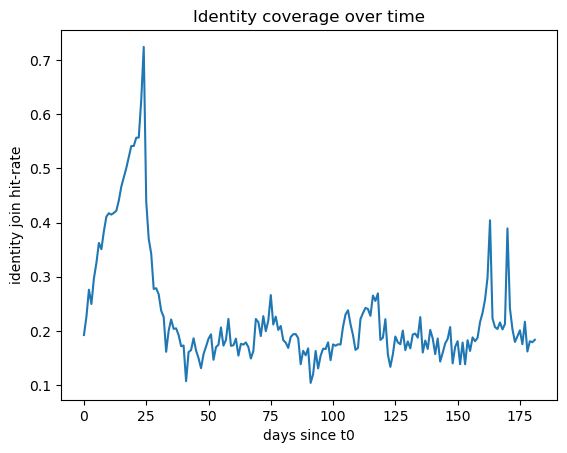

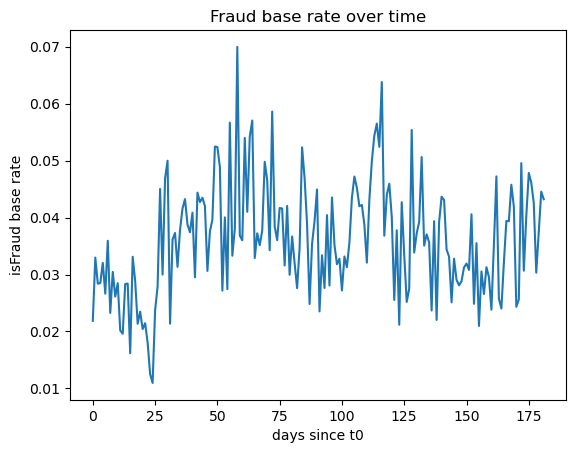

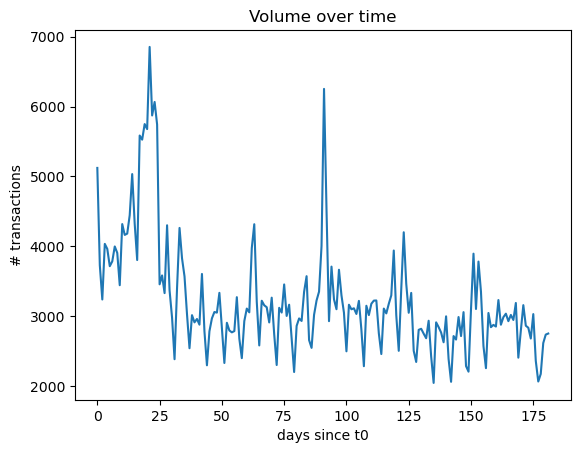

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)

# ---------- Paths (edit if your layout differs) ----------
DATA_DIR = Path("../data/raw")
TX_TRAIN = DATA_DIR / "train_transaction.csv"
ID_TRAIN = DATA_DIR / "train_identity.csv"

# ---------- Minimal columns for this step ----------
usecols_tx = ["TransactionID", "isFraud", "TransactionDT", "TransactionAmt"]  # Amt kept for later bands
usecols_id = ["TransactionID"]

tx = pd.read_csv(TX_TRAIN, usecols=usecols_tx)
idn = pd.read_csv(ID_TRAIN, usecols=usecols_id)

# ---------- Sanity checks ----------
assert tx["TransactionID"].is_unique, "Duplicate TransactionID in train_transaction."
assert idn["TransactionID"].is_unique, "Duplicate TransactionID in train_identity."
assert "isFraud" in tx.columns, "isFraud not found (use train_transaction for this cell)."

# ---------- Relative time buckets (DON'T convert to real datetime) ----------
SECONDS_PER_HOUR = 3600
SECONDS_PER_DAY = 24 * 3600
SECONDS_PER_WEEK = 7 * 24 * 3600

t0 = int(tx["TransactionDT"].min())
tx["dt_hours"] = ((tx["TransactionDT"] - t0) // SECONDS_PER_HOUR).astype("int32")
tx["dt_days"]  = ((tx["TransactionDT"] - t0) // SECONDS_PER_DAY).astype("int32")
tx["dt_weeks"] = ((tx["TransactionDT"] - t0) // SECONDS_PER_WEEK).astype("int32")

# ---------- Identity join coverage ----------
tx = tx.merge(idn.assign(is_identity_present=1), on="TransactionID", how="left")
tx["is_identity_present"] = tx["is_identity_present"].fillna(0).astype("int8")

# ---------- Overview table ----------
overview = pd.DataFrame({
    "n_rows": [len(tx)],
    "n_unique_txid": [tx["TransactionID"].nunique()],
    "isFraud_base_rate": [tx["isFraud"].mean()],
    "identity_hit_rate": [tx["is_identity_present"].mean()],
    "TransactionDT_min": [tx["TransactionDT"].min()],
    "TransactionDT_max": [tx["TransactionDT"].max()],
}).T
display(overview.rename(columns={0: "value"}))

# ---------- Time-evolution diagnostics ----------
join_by_day = (tx.groupby("dt_days")["is_identity_present"]
                 .mean().rename("identity_hit_rate").reset_index())
fraud_by_day = (tx.groupby("dt_days")["isFraud"]
                  .mean().rename("isFraud_rate").reset_index())
vol_by_day = (tx.groupby("dt_days")
                .size().rename("n_tx").reset_index())

# Identity join hit-rate over time
fig, ax = plt.subplots()
ax.plot(join_by_day["dt_days"], join_by_day["identity_hit_rate"])
ax.set_xlabel("days since t0")
ax.set_ylabel("identity join hit-rate")
ax.set_title("Identity coverage over time")
plt.show()

# Fraud base rate over time
fig, ax = plt.subplots()
ax.plot(fraud_by_day["dt_days"], fraud_by_day["isFraud_rate"])
ax.set_xlabel("days since t0")
ax.set_ylabel("isFraud base rate")
ax.set_title("Fraud base rate over time")
plt.show()

# Transaction volume over time (sanity for drift/seasonality)
fig, ax = plt.subplots()
ax.plot(vol_by_day["dt_days"], vol_by_day["n_tx"])
ax.set_xlabel("days since t0")
ax.set_ylabel("# transactions")
ax.set_title("Volume over time")
plt.show()

# Category 2: Time & Amount (clean, leak-safe).
It builds cyclical time views (hour/day-of-week on the relative axis), creates amount bands (micro / typical / high), and visualizes drift.

## What Plots Suggest (Quick Take)

### Temporal Patterns
- **Clear diurnal cycle**: volume trough ~7–10 (relative hours), peaks ~19–21. Fraud rate **peaks in the early morning (~6–8)** when volume is low → classic "quiet-hours" effect
- **Weekly rhythm (relative)**: lowest fraud on day 3; modest rise by day 6. Differences are small but real
- **Base-rate drift**: your 7-day MA shows a mid-period lift → concept drift exists; keep **time-based CV**

### Amount Distribution & Risk
- **Amount distribution**: heavy spikes (favorite price points)
- **Risk vs amount**: **U-shaped**—micro (6.1%) > high (5.1%) > typical (3.3%). Micro is only **0.22%** of volume but high-risk; high-amount is ~11.3% and also riskier
- **Drift in amounts**: p90 fairly stable with slight sag mid-period; **p99 bounces a lot** (rare big purchases). Micro share spikes late → watch for interactions with time

## Lock-ins for Later

### Feature Engineering
- Keep `log_amt`, `is_micro_amt`, `is_high_amt` (and `amt_band`)
- Consider **sin/cos** of hour-of-day (relative) for models

### Reporting Strategy
- Always report metrics split by `is_identity_present` and by `amt_band`

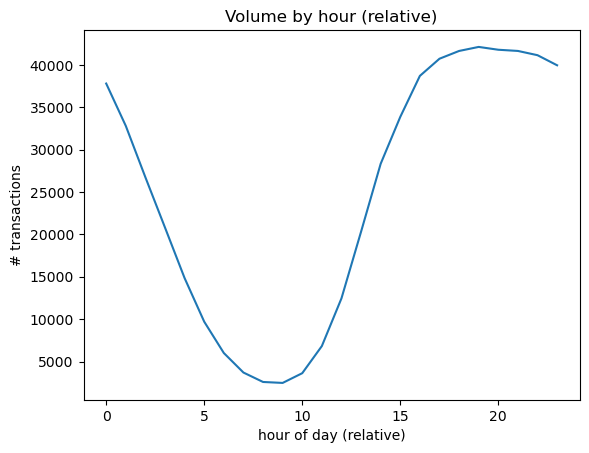

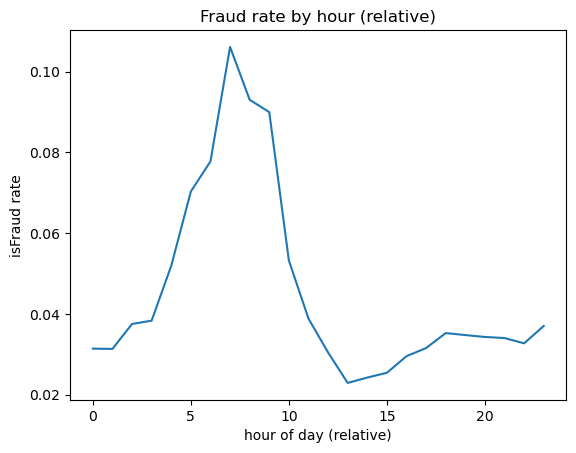

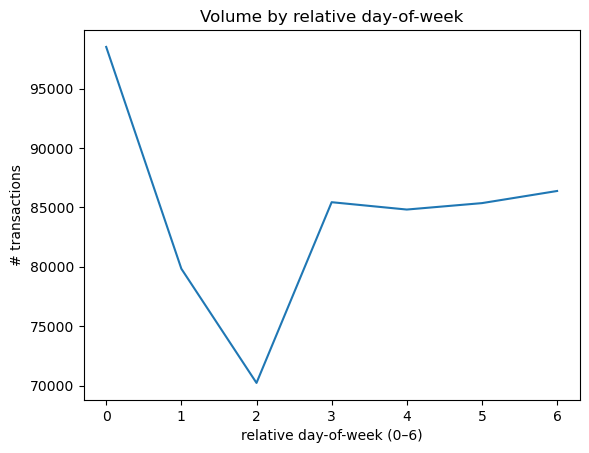

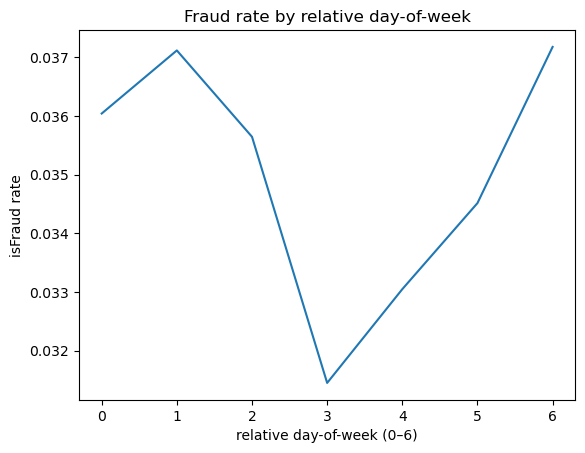

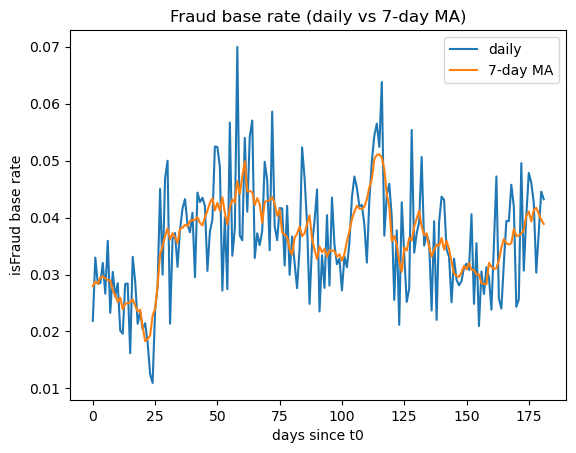

[bands] micro_thr = 5.00, high_thr = 247.52
amt_band
typical    0.885173
high       0.112578
micro      0.002249
Name: share_by_band, dtype: float64


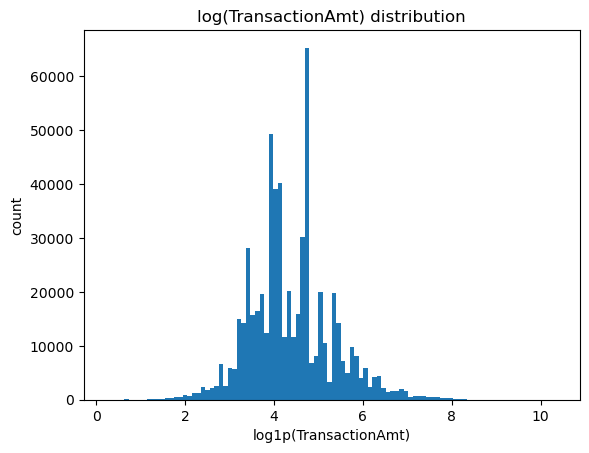

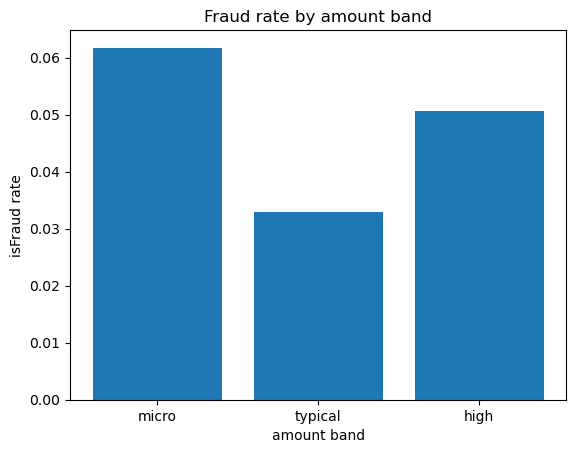

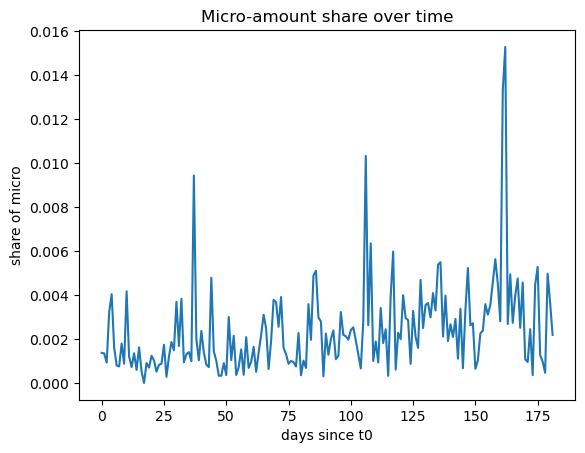

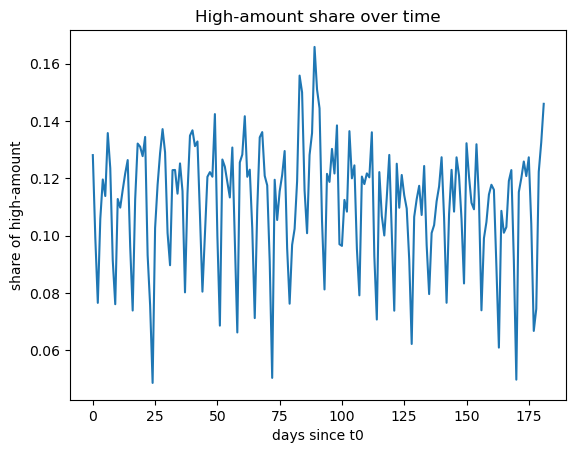

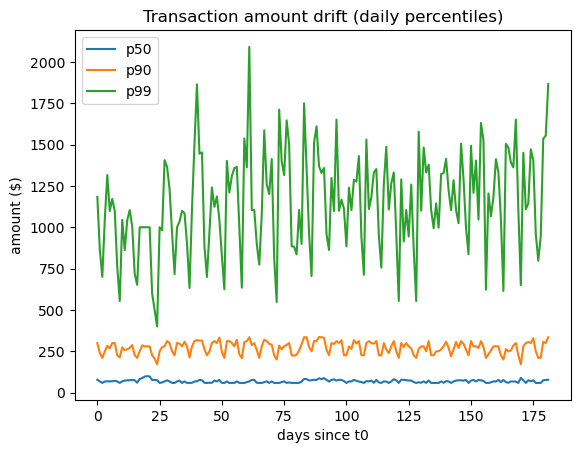

In [2]:
# 02-time_and_amount (Category 2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Assumptions from Category 1 ----
# `tx` exists and already has: TransactionID, isFraud, TransactionDT, TransactionAmt,
# and dt_hours / dt_days / dt_weeks plus t0 defined in your session.
assert "tx" in globals(), "Run the Category 1 cell first to create `tx`."

# =========================
# A) Cyc patterns (relative)
# =========================
# Hour-of-day and relative day-of-week from the RELATIVE timestamp.
# Note: day-of-week here is cyclical (mod 7) on the relative axis, not a real calendar weekday.
tx["hod"] = ((tx["TransactionDT"] - tx["TransactionDT"].min()) // 3600) % 24
tx["dow_rel"] = ((tx["TransactionDT"] - tx["TransactionDT"].min()) // (24 * 3600)) % 7

hod_stats = (tx.groupby("hod")
               .agg(n_tx=("TransactionID", "size"),
                    fraud_rate=("isFraud", "mean"),
                    mean_amt=("TransactionAmt", "mean"))
               .reset_index())

dow_stats = (tx.groupby("dow_rel")
               .agg(n_tx=("TransactionID", "size"),
                    fraud_rate=("isFraud", "mean"),
                    mean_amt=("TransactionAmt", "mean"))
               .reset_index())

# Transactions by hour of day
fig, ax = plt.subplots()
ax.plot(hod_stats["hod"], hod_stats["n_tx"])
ax.set_xlabel("hour of day (relative)")
ax.set_ylabel("# transactions")
ax.set_title("Volume by hour (relative)")
plt.show()

# Fraud rate by hour of day
fig, ax = plt.subplots()
ax.plot(hod_stats["hod"], hod_stats["fraud_rate"])
ax.set_xlabel("hour of day (relative)")
ax.set_ylabel("isFraud rate")
ax.set_title("Fraud rate by hour (relative)")
plt.show()

# Transactions by relative day-of-week
fig, ax = plt.subplots()
ax.plot(dow_stats["dow_rel"], dow_stats["n_tx"])
ax.set_xlabel("relative day-of-week (0–6)")
ax.set_ylabel("# transactions")
ax.set_title("Volume by relative day-of-week")
plt.show()

# Fraud rate by relative day-of-week
fig, ax = plt.subplots()
ax.plot(dow_stats["dow_rel"], dow_stats["fraud_rate"])
ax.set_xlabel("relative day-of-week (0–6)")
ax.set_ylabel("isFraud rate")
ax.set_title("Fraud rate by relative day-of-week")
plt.show()

# ==========================================
# B) Daily base-rate smoothing (drift sanity)
# ==========================================
daily = (tx.groupby("dt_days")
           .agg(n_tx=("TransactionID", "size"),
                base_rate=("isFraud", "mean"),
                median_amt=("TransactionAmt", "median"))
           .reset_index())
daily["base_rate_ma7"] = daily["base_rate"].rolling(7, min_periods=1, center=True).mean()

# Base rate (raw) vs 7-day MA
fig, ax = plt.subplots()
ax.plot(daily["dt_days"], daily["base_rate"], label="daily")
ax.plot(daily["dt_days"], daily["base_rate_ma7"], label="7-day MA")
ax.set_xlabel("days since t0")
ax.set_ylabel("isFraud base rate")
ax.set_title("Fraud base rate (daily vs 7-day MA)")
ax.legend()
plt.show()

# =====================================
# C) TransactionAmt bands & drift views
# =====================================
# Log-transform & banding
tx["log_amt"] = np.log1p(tx["TransactionAmt"])

q1, q3 = tx["TransactionAmt"].quantile([0.25, 0.75])
iqr = float(q3 - q1)
high_thr = float(q3 + 1.5 * iqr)   # Tukey-style high outlier threshold
micro_thr = 5.0                    # user-defined micro threshold

tx["is_micro_amt"] = (tx["TransactionAmt"] < micro_thr).astype("int8")
tx["is_high_amt"]  = (tx["TransactionAmt"] > high_thr).astype("int8")

conditions = [tx["TransactionAmt"] < micro_thr, tx["TransactionAmt"] > high_thr]
choices = ["micro", "high"]
tx["amt_band"] = np.select(conditions, choices, default="typical")

print(f"[bands] micro_thr = {micro_thr:.2f}, high_thr = {high_thr:.2f}")
print(tx["amt_band"].value_counts(normalize=True).rename("share_by_band"))

# Log-amount histogram (shape only; not a feature decision)
fig, ax = plt.subplots()
ax.hist(tx["log_amt"], bins=100)
ax.set_xlabel("log1p(TransactionAmt)")
ax.set_ylabel("count")
ax.set_title("log(TransactionAmt) distribution")
plt.show()

# Fraud rate by amount band
band_fraud = (tx.groupby("amt_band")["isFraud"]
                .mean().reindex(["micro", "typical", "high"]))
fig, ax = plt.subplots()
ax.bar(band_fraud.index.astype(str), band_fraud.values)
ax.set_xlabel("amount band")
ax.set_ylabel("isFraud rate")
ax.set_title("Fraud rate by amount band")
plt.show()

# Share of micro/high over time
band_share_by_day = (tx.groupby("dt_days")
                       .agg(micro_share=("is_micro_amt", "mean"),
                            high_share=("is_high_amt", "mean"),
                            avg_amt=("TransactionAmt", "mean"))
                       .reset_index())

fig, ax = plt.subplots()
ax.plot(band_share_by_day["dt_days"], band_share_by_day["micro_share"])
ax.set_xlabel("days since t0")
ax.set_ylabel("share of micro")
ax.set_title("Micro-amount share over time")
plt.show()

fig, ax = plt.subplots()
ax.plot(band_share_by_day["dt_days"], band_share_by_day["high_share"])
ax.set_xlabel("days since t0")
ax.set_ylabel("share of high-amount")
ax.set_title("High-amount share over time")
plt.show()

# Amount drift percentiles over time (median, p90, p99)
q = (tx.groupby("dt_days")["TransactionAmt"]
       .quantile([0.5, 0.9, 0.99])
       .unstack())
q.columns = ["p50", "p90", "p99"]

fig, ax = plt.subplots()
ax.plot(q.index, q["p50"], label="p50")
ax.plot(q.index, q["p90"], label="p90")
ax.plot(q.index, q["p99"], label="p99")
ax.set_xlabel("days since t0")
ax.set_ylabel("amount ($)")
ax.set_title("Transaction amount drift (daily percentiles)")
ax.legend()
plt.show()

# Category 3: Product & Payment Instrument (ProductCD, card1–card6)

This chunk: loads the columns, merges, gives per-column summaries, risk by level, and stability over time for the low-cardinality ones (ProductCD/card4/card6). It also inspects long-tail behavior for high-cardinality card fields.

## Interpretation — Product & Instrument
- ProductCD: W dominates (≈75–85% share) and is lowest risk (~2%). C is a smaller but high-risk segment (~11–12% fraud). Its share drifts a bit (e.g., week ~16 uptick) → useful interaction target (e.g., C × amount band).
- card4 (network): Shares are very stable (Visa ~65%, MC ~32%). Discover has the highest fraud rate (~7.7%) despite tiny share → real signal; still smooth/regularize in modeling.
- card6 (type): Credit (~6.7%) ≫ Debit (~2.4%) for fraud rate, consistent across weeks → very predictive.
- High-card fields (card1/2/3/5): Long tails and some levels with eye-popping rates (e.g., card3=185). Many of these reflect small cohorts or era effects → avoid naive global target encoding; prefer time-aware, smoothed encoders + frequency/rarity buckets.


=== Low-cardinality summaries (top 10) ===

[ProductCD] nunique=5, missing_share=0.000, tail_share(top10)=0.000


,ProductCD,count,fraud_rate,share
0,W,439670,0.020399,0.744522
1,C,68519,0.116873,0.116028
2,R,37699,0.037826,0.063838
3,H,33024,0.047662,0.055922
4,S,11628,0.058996,0.019690



[card4] nunique=4, missing_share=0.003, tail_share(top10)=0.000


,card4,count,fraud_rate,share
0,visa,384767,0.034756,0.651551
1,mastercard,189217,0.034331,0.320414
2,american express,8328,0.028698,0.014102
3,discover,6651,0.077282,0.011263
4,__NA__,1577,0.025999,0.002670



[card6] nunique=4, missing_share=0.003, tail_share(top10)=0.000


,card6,count,fraud_rate,share
0,debit,439938,0.024263,0.744976
1,credit,148986,0.066785,0.252288
2,__NA__,1571,0.024825,0.002660
3,debit or credit,30,0.000000,0.000051
4,charge card,15,0.000000,0.000025



=== High-cardinality snapshots (top 15) ===

[card1] nunique≈13553, missing_share=0.000, tail_share(top15)=0.808


/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_10243/2415575004.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  s = df[col].astype("object").fillna("__NA__")


,card1,count,fraud_rate,share
0,7919,14932,0.007501,0.025285
1,9500,14162,0.037283,0.023981
2,15885,10361,0.042853,0.017545
3,17188,10344,0.026875,0.017516
4,15066,7945,0.039396,0.013454
5,12695,7091,0.028346,0.012008
6,12544,6773,0.021556,0.011469
7,6019,6771,0.043420,0.011466
8,2803,6141,0.011887,0.010399
9,7585,5334,0.049306,0.009032



[card2] nunique≈500, missing_share=0.015, tail_share(top15)=0.452


,card2,count,fraud_rate,share
0,321.0,48935,0.028528,0.082865
1,111.0,45191,0.021641,0.076525
2,555.0,41995,0.022836,0.071113
3,490.0,38145,0.024014,0.064593
4,583.0,21803,0.041233,0.036920
5,170.0,18214,0.031295,0.030843
6,194.0,16938,0.007675,0.028682
7,545.0,16355,0.086824,0.027695
8,360.0,15190,0.010402,0.025722
9,514.0,14541,0.046214,0.024623



[card3] nunique≈114, missing_share=0.003, tail_share(top15)=0.005


,card3,count,fraud_rate,share
0,150.0,521287,0.024568,0.882729
1,185.0,56346,0.130657,0.095414
2,106.0,1571,0.015277,0.002660
3,__NA__,1565,0.024920,0.002650
4,146.0,1252,0.019968,0.002120
5,144.0,1252,0.089457,0.002120
6,117.0,962,0.018711,0.001629
7,143.0,899,0.031146,0.001522
8,119.0,750,0.093333,0.001270
9,102.0,460,0.023913,0.000779



[card5] nunique≈119, missing_share=0.007, tail_share(top15)=0.021


,card5,count,fraud_rate,share
0,226.0,296546,0.029516,0.502161
1,224.0,81513,0.038669,0.138031
2,166.0,57140,0.011026,0.096759
3,102.0,29105,0.062945,0.049285
4,117.0,25941,0.013646,0.043928
5,138.0,19737,0.085221,0.033422
6,195.0,16945,0.040189,0.028694
7,137.0,11720,0.147184,0.019846
8,126.0,10298,0.010196,0.017438
9,219.0,9924,0.057537,0.016805



=== Analysis for ProductCD ===


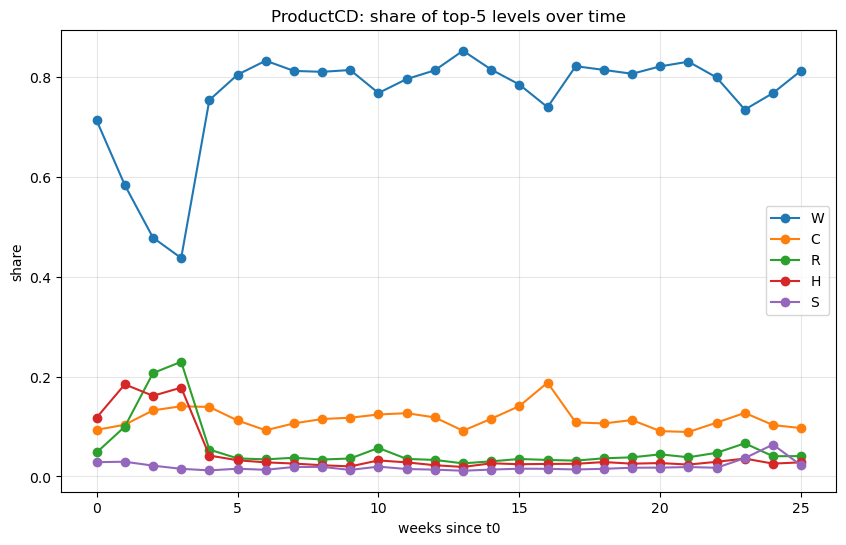

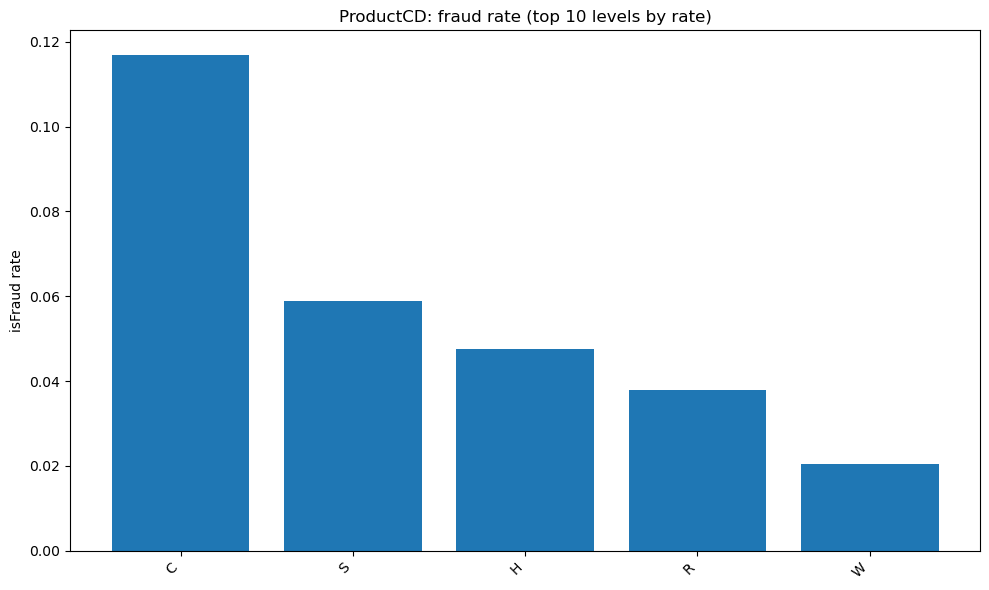


=== Analysis for card4 ===


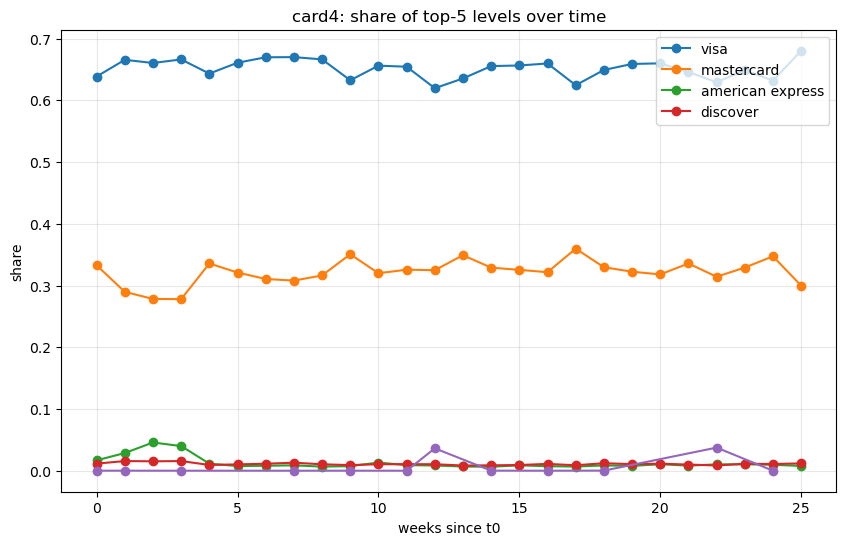

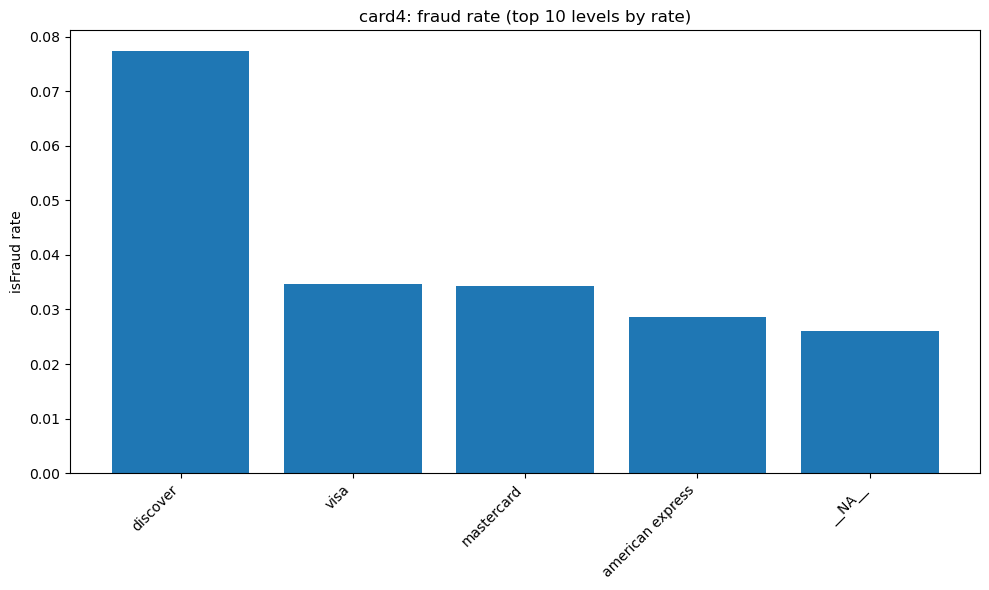


=== Analysis for card6 ===


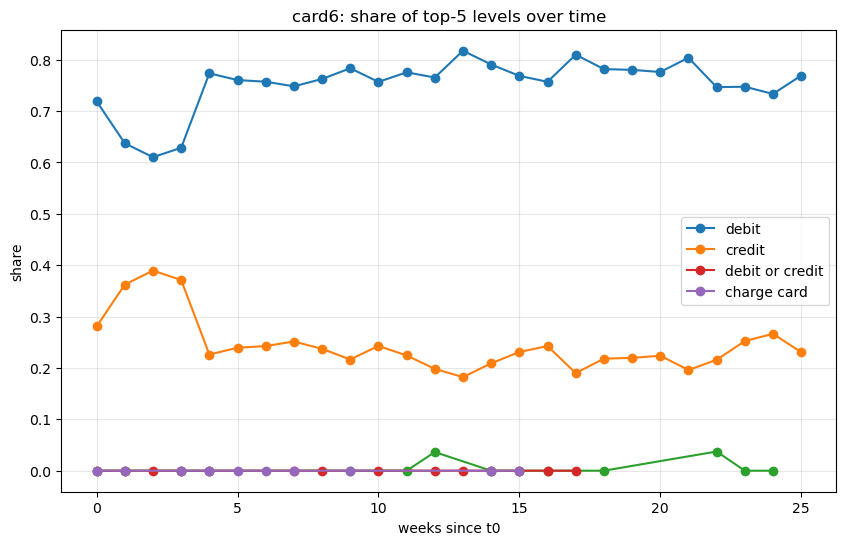

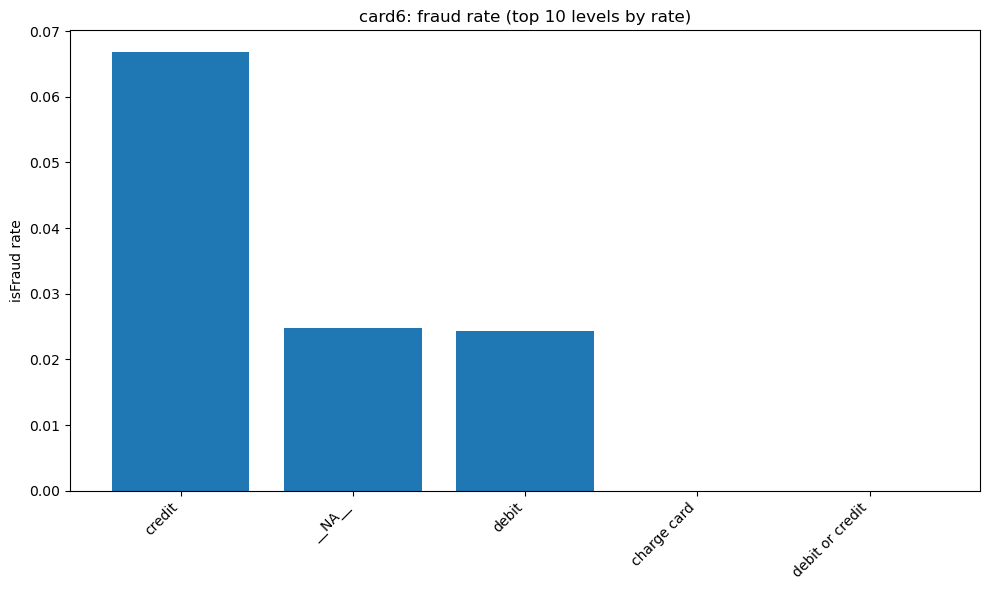


=== High-cardinality health checks ===

=== Analysis for card1 ===


/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_10243/2415575004.py:109: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  s = df[col].astype("object").fillna("__NA__")


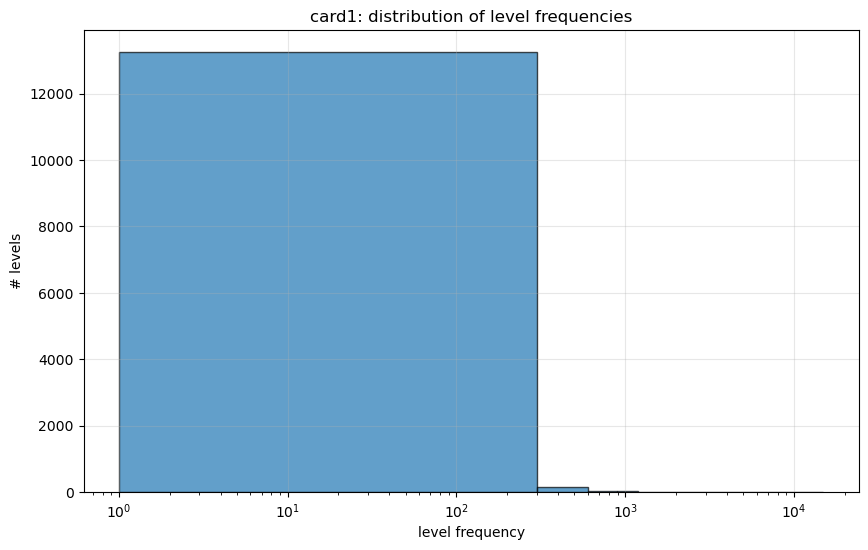

[card1] rare_min_count=100 → rare_share=0.221, rare_fr=0.0273, common_fr=0.0372

Top-10 card1 levels by count — fraud rate (desc):


_cat
7585     0.049306
6019     0.043420
15885    0.042853
15066    0.039396
9500     0.037283
12695    0.028346
17188    0.026875
12544    0.021556
2803     0.011887
7919     0.007501
Name: target, dtype: float64


Top-50 card1 levels by count — fraud rate (desc):


_cat
9026     0.191233
9633     0.178451
15063    0.126487
5812     0.111427
13832    0.095053
4461     0.074088
2616     0.071202
3154     0.061985
10486    0.056287
7585     0.049306
Name: target, dtype: float64


Top-100 card1 levels by count — fraud rate (desc):


_cat
9026     0.191233
8755     0.179279
9633     0.178451
2256     0.174981
15063    0.126487
9002     0.114151
5812     0.111427
13832    0.095053
11201    0.084844
4461     0.074088
Name: target, dtype: float64


=== Analysis for card2 ===


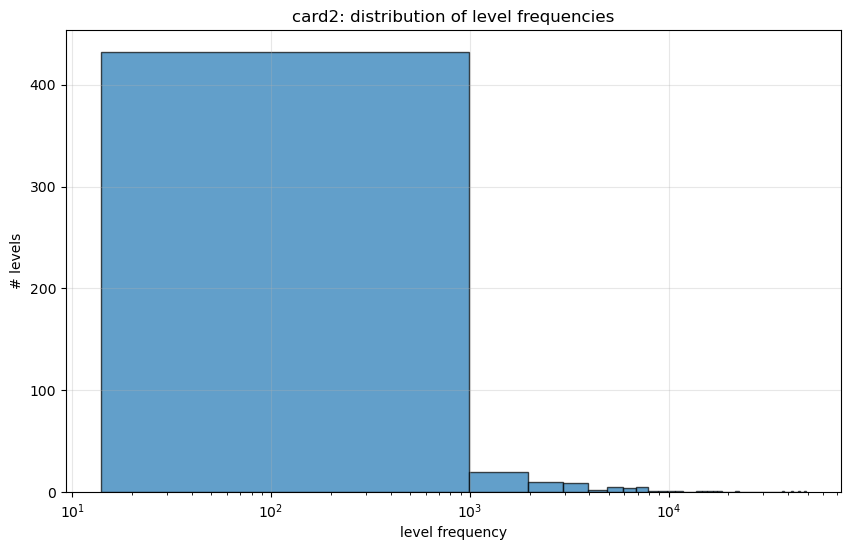

[card2] rare_min_count=100 → rare_share=0.017, rare_fr=0.0128, common_fr=0.0354

Top-10 card2 levels by count — fraud rate (desc):


_cat
545.0    0.086824
514.0    0.046214
583.0    0.041233
170.0    0.031295
321.0    0.028528
490.0    0.024014
555.0    0.022836
111.0    0.021641
360.0    0.010402
194.0    0.007675
Name: target, dtype: float64


Top-50 card2 levels by count — fraud rate (desc):


_cat
130.0    0.239257
296.0    0.191971
500.0    0.180575
103.0    0.099481
327.0    0.088627
204.0    0.087508
545.0    0.086824
408.0    0.083999
375.0    0.080029
404.0    0.065118
Name: target, dtype: float64


Top-100 card2 levels by count — fraud rate (desc):


_cat
104.0    0.248011
177.0    0.241169
142.0    0.240356
130.0    0.239257
459.0    0.199409
296.0    0.191971
266.0    0.191514
500.0    0.180575
529.0    0.180371
103.0    0.099481
Name: target, dtype: float64


=== Analysis for card3 ===


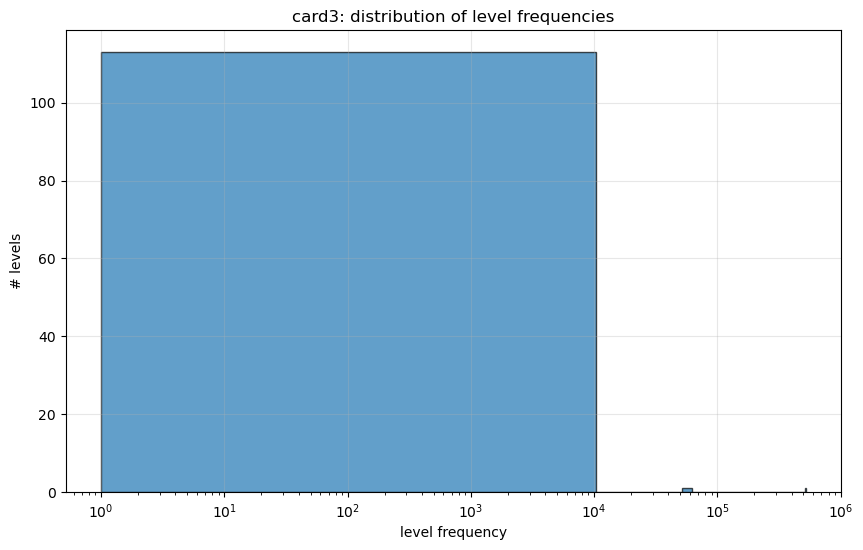

[card3] rare_min_count=100 → rare_share=0.003, rare_fr=0.0682, common_fr=0.0349

Top-10 card3 levels by count — fraud rate (desc):


_cat
185.0     0.130657
119.0     0.093333
144.0     0.089457
143.0     0.031146
__NA__    0.024920
150.0     0.024568
102.0     0.023913
146.0     0.019968
117.0     0.018711
106.0     0.015277
Name: target, dtype: float64


Top-50 card3 levels by count — fraud rate (desc):


_cat
191.0    0.388889
223.0    0.254545
118.0    0.235294
198.0    0.193548
182.0    0.179487
127.0    0.142857
185.0    0.130657
142.0    0.125000
119.0    0.093333
214.0    0.090909
Name: target, dtype: float64


Top-100 card3 levels by count — fraud rate (desc):


_cat
181.0    1.000000
160.0    1.000000
206.0    1.000000
208.0    0.500000
191.0    0.388889
155.0    0.333333
223.0    0.254545
167.0    0.250000
118.0    0.235294
129.0    0.222222
Name: target, dtype: float64


=== Analysis for card5 ===


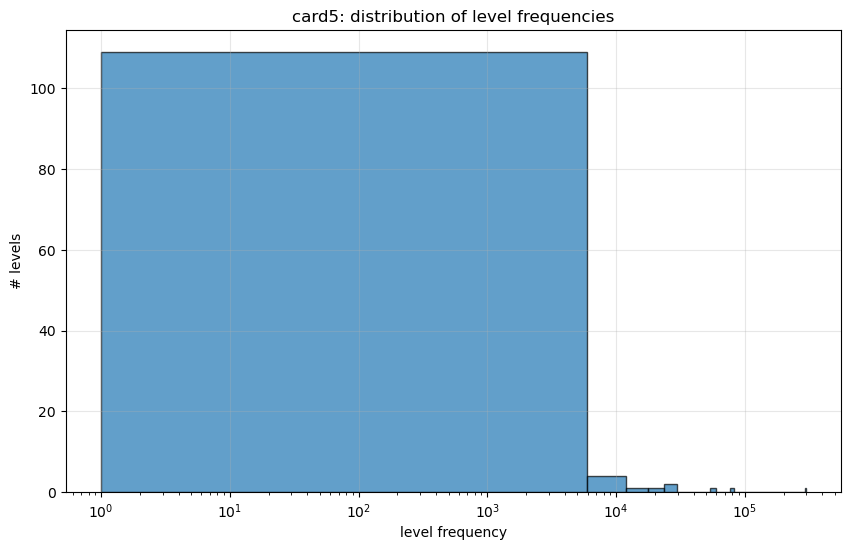

[card5] rare_min_count=100 → rare_share=0.002, rare_fr=0.0267, common_fr=0.0350

Top-10 card5 levels by count — fraud rate (desc):


_cat
137.0    0.147184
138.0    0.085221
102.0    0.062945
219.0    0.057537
195.0    0.040189
224.0    0.038669
226.0    0.029516
117.0    0.013646
166.0    0.011026
126.0    0.010196
Name: target, dtype: float64


Top-50 card5 levels by count — fraud rate (desc):


_cat
137.0    0.147184
212.0    0.119048
147.0    0.112710
141.0    0.093842
143.0    0.093023
223.0    0.088675
138.0    0.085221
144.0    0.073059
162.0    0.066534
203.0    0.065421
Name: target, dtype: float64


Top-100 card5 levels by count — fraud rate (desc):


_cat
191.0    0.500000
107.0    0.333333
139.0    0.230769
137.0    0.147184
212.0    0.119048
147.0    0.112710
141.0    0.093842
143.0    0.093023
223.0    0.088675
138.0    0.085221
Name: target, dtype: float64

In [3]:
# 03-product_instrument (Category 3)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Assumes you ran Category 1/2 and have `tx`, TX_TRAIN path, and dt_weeks available ----
assert "tx" in globals(), "Run Category 1/2 to create `tx` first."
assert "TX_TRAIN" in globals(), "Path TX_TRAIN not found; ensure Category 1 cell ran."

# 1) Load only needed product/instrument cols and merge
usecols_pi = ["TransactionID", "ProductCD", "card1", "card2", "card3", "card4", "card5", "card6"]
tx_pi = pd.read_csv(TX_TRAIN, usecols=usecols_pi)
tx = tx.merge(tx_pi, on="TransactionID", how="left")

# 2) Helper: categorical summary with fraud rates and long-tail share
def cat_summary(df, col, target="isFraud", topn=10):
    s = df[col].astype("object").fillna("__NA__")
    tmp = pd.DataFrame({col: s, target: df[target].values})
    vc = s.value_counts()
    n = int(vc.sum())
    nunique = int((s.unique() != "__NA__").sum()) if "__NA__" in s.unique() else s.nunique()
    miss_share = float((df[col].isna()).mean())

    top = (tmp.groupby(col)
             .agg(count=(target, "size"), fraud_rate=(target, "mean"))
             .sort_values("count", ascending=False)
             .head(topn))
    top["share"] = top["count"] / n
    tail_share = float(1.0 - top["share"].sum())
    return {
        "nunique": nunique,
        "missing_share": miss_share,
        "top_table": top.reset_index(),
        "tail_share": tail_share,
    }

# 3) Run summaries
cats_low = ["ProductCD", "card4", "card6"]   # typically low-card
cats_high = ["card1", "card2", "card3", "card5"]  # typically high-card

print("=== Low-cardinality summaries (top 10) ===")
low_summ = {c: cat_summary(tx, c) for c in cats_low}
for c, summ in low_summ.items():
    print(f"\n[{c}] nunique={summ['nunique']}, missing_share={summ['missing_share']:.3f}, tail_share(top10)={summ['tail_share']:.3f}")
    display(summ["top_table"])

print("\n=== High-cardinality snapshots (top 15) ===")
high_summ = {}
for c in cats_high:
    summ = cat_summary(tx, c, topn=15)
    high_summ[c] = summ
    print(f"\n[{c}] nunique≈{summ['nunique']}, missing_share={summ['missing_share']:.3f}, tail_share(top15)={summ['tail_share']:.3f}")
    display(summ["top_table"])

# 4) Stability over time for low-card columns: share by week + fraud by level
def plot_share_over_time(df, col, time_col="dt_weeks", topk=5):
    s = df[col].astype("object").fillna("__NA__")
    top_levels = s.value_counts().head(topk).index.tolist()
    tmp = df.assign(_cat=s)
    
    # Calculate shares by time period and category
    time_cat_counts = tmp.groupby([time_col, "_cat"]).size().reset_index(name='count')
    time_totals = tmp.groupby(time_col).size().reset_index(name='total')
    
    # Merge and calculate shares
    merged = time_cat_counts.merge(time_totals, on=time_col)
    merged['share'] = merged['count'] / merged['total']
    
    # Filter to top levels only
    shares_top = merged[merged['_cat'].isin(top_levels)]
    
    plt.figure(figsize=(10, 6))
    for level in top_levels:
        level_data = shares_top[shares_top['_cat'] == level]
        if len(level_data) > 0:
            plt.plot(level_data[time_col], level_data['share'], 
                    label=str(level), marker='o')
    
    plt.xlabel("weeks since t0")
    plt.ylabel("share")
    plt.title(f"{col}: share of top-{topk} levels over time")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_fraud_by_level(df, col, topn=10):
    s = df[col].astype("object").fillna("__NA__")
    tmp = pd.DataFrame({"_cat": s, "target": df["isFraud"].values})
    fr = (tmp.groupby("_cat")["target"].mean()
            .sort_values(ascending=False)
            .head(topn))
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(fr)), fr.values)
    plt.xticks(range(len(fr)), [str(x) for x in fr.index], rotation=45, ha="right")
    plt.ylabel("isFraud rate")
    plt.title(f"{col}: fraud rate (top {topn} levels by rate)")
    plt.tight_layout()
    plt.show()

for c in cats_low:
    print(f"\n=== Analysis for {c} ===")
    plot_share_over_time(tx, c, time_col="dt_weeks", topk=5)
    plot_fraud_by_level(tx, c, topn=10)

# 5) High-cardinality health checks: frequency distribution & rare-level behavior
def high_card_health(df, col, rare_min_count=100, topn_list=(10, 50, 100)):
    s = df[col].astype("object").fillna("__NA__")
    vc = s.value_counts()
    
    # Frequency distribution (log x-axis)
    plt.figure(figsize=(10, 6))
    plt.hist(vc.values, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel("level frequency")
    plt.ylabel("# levels")
    plt.title(f"{col}: distribution of level frequencies")
    plt.xscale("log")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Rare level share and fraud
    rare_levels = set(vc[vc < rare_min_count].index.tolist())
    rare_share = float(vc[vc < rare_min_count].sum() / vc.sum())
    tmp = pd.DataFrame({"_cat": s, "target": df["isFraud"].values})
    rare_fr = tmp[tmp["_cat"].isin(rare_levels)]["target"].mean() if rare_levels else np.nan
    common_fr = tmp[~tmp["_cat"].isin(rare_levels)]["target"].mean() if rare_levels else tmp["target"].mean()
    print(f"[{col}] rare_min_count={rare_min_count} → rare_share={rare_share:.3f}, rare_fr={rare_fr:.4f}, common_fr={common_fr:.4f}")

    # Top-N most common levels by count with fraud rates (sanity)
    for topn in topn_list:
        top_levels = vc.head(topn).index
        fr = (tmp[tmp["_cat"].isin(top_levels)]
              .groupby("_cat")["target"].mean()
              .sort_values(ascending=False))
        print(f"\nTop-{topn} {col} levels by count — fraud rate (desc):")
        display(fr.head(10))

print("\n=== High-cardinality health checks ===")
for c in cats_high:
    print(f"\n=== Analysis for {c} ===")
    high_card_health(tx, c, rare_min_count=100)

# Category 4: Geo / Contact Proxies (addr*, dist*, P_/R_emaildomain)

This chunk normalizes email domains (parent domain + freemail flags), profiles addr* and dist*, and checks missingness & risk. Run as-is after your existing cells.

=== EMAIL DOMAIN VALUE COUNTS ===

P_emaildomain (original) - Top 20:


P_emaildomain
gmail.com        228355
yahoo.com        103522
__NA__            94456
hotmail.com       45962
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
att.net            4033
live.com           3790
sbcglobal.net      2970
verizon.net        2705
bellsouth.net      1909
yahoo.com.mx       1543
me.com             1522
cox.net            1393
optonline.net      1011
charter.net         816
Name: count, dtype: int64


R_emaildomain (original) - Top 20:


R_emaildomain
__NA__           453249
gmail.com         57147
hotmail.com       28199
anonymous.com     20529
yahoo.com         12225
aol.com            3701
outlook.com        2507
comcast.net        1812
live.com           1516
yahoo.com.mx       1508
icloud.com         1398
msn.com             852
verizon.net         620
me.com              556
sbcglobal.net       552
cox.net             459
outlook.es          433
att.net             430
bellsouth.net       422
web.de              237
Name: count, dtype: int64


P_ed_parent (normalized) - Top 20:


P_ed_parent
gmail.com        228355
yahoo.com        103522
__NA__            94456
hotmail.com       45962
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
att.net            4033
live.com           3790
sbcglobal.net      2970
verizon.net        2705
bellsouth.net      1909
yahoo.com.mx       1543
me.com             1522
cox.net            1393
optonline.net      1011
charter.net         816
Name: count, dtype: int64


R_ed_parent (normalized) - Top 20:


R_ed_parent
__NA__           453249
gmail.com         57147
hotmail.com       28199
anonymous.com     20529
yahoo.com         12225
aol.com            3701
outlook.com        2507
comcast.net        1812
live.com           1516
yahoo.com.mx       1508
icloud.com         1398
msn.com             852
verizon.net         620
me.com              556
sbcglobal.net       552
cox.net             459
outlook.es          433
att.net             430
bellsouth.net       422
web.de              237
Name: count, dtype: int64


Missing rates:
P_emaildomain: 0.000
R_emaildomain: 0.000
P_ed_parent: 0.160
R_ed_parent: 0.768

Freemail vs Corporate:
P_emaildomain - Freemail: 0.760
R_emaildomain - Freemail: 0.191
Email parent domains match: 0.315


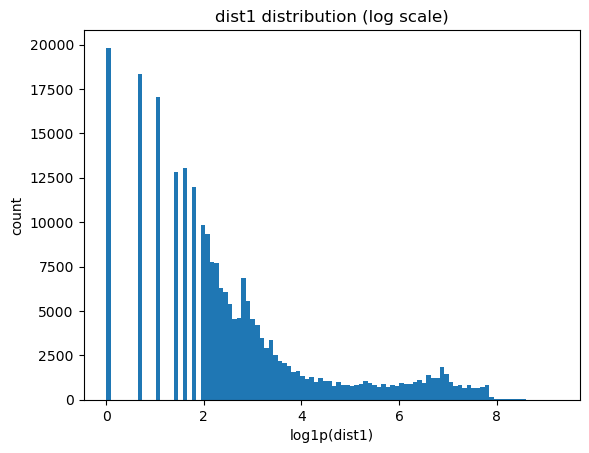

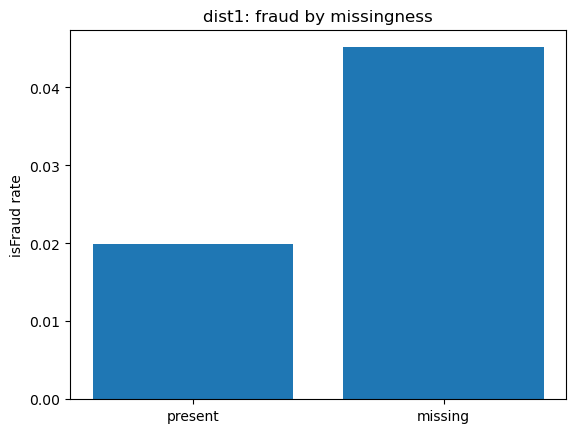

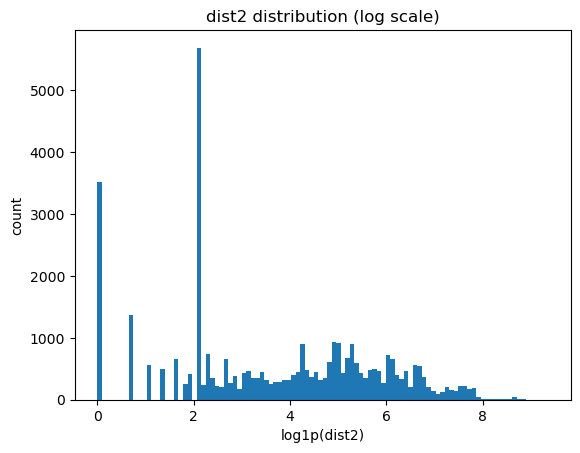

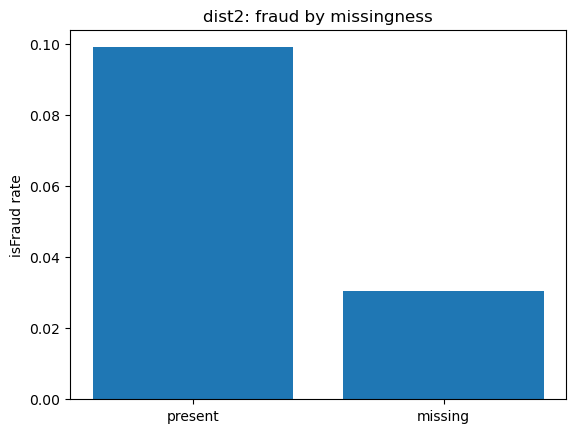

addr1 top levels by count:


,addr1,count,fraud_rate
0,299.0,46335,0.021258
1,325.0,42751,0.025426
2,204.0,42020,0.026654
3,264.0,39870,0.018259
4,330.0,26287,0.031955
5,315.0,23078,0.017809
6,441.0,20827,0.025592
7,272.0,20141,0.028598
8,123.0,16105,0.024713
9,126.0,15243,0.025323


addr2 top levels by count:


,addr2,count,fraud_rate
0,87.0,520481,0.023972
1,60.0,3084,0.090467
2,96.0,638,0.139498
3,32.0,91,0.065934
4,65.0,82,0.536585
5,16.0,55,0.000000
6,31.0,47,0.000000
7,19.0,33,0.000000
8,26.0,25,0.000000
9,27.0,20,0.000000


P_email parent domains (top 15):


,P_ed_parent,count,fraud_rate
0,gmail.com,228355,0.043542
1,yahoo.com,103522,0.022720
2,__NA__,94456,0.029538
3,hotmail.com,45962,0.052565
4,anonymous.com,36998,0.023217
5,aol.com,28289,0.021811
6,comcast.net,7888,0.031187
7,icloud.com,6267,0.031434
8,outlook.com,5096,0.094584
9,msn.com,4092,0.021994


R_email parent domains (top 15):


,R_ed_parent,count,fraud_rate
0,__NA__,453249,0.020819
1,gmail.com,57147,0.119184
2,hotmail.com,28199,0.076598
3,anonymous.com,20529,0.029130
4,yahoo.com,12225,0.050961
5,aol.com,3701,0.034855
6,outlook.com,2507,0.165138
7,comcast.net,1812,0.011589
8,live.com,1516,0.054090
9,yahoo.com.mx,1508,0.010610


Email-category fraud summary:


,value
P_freemail_rate,0.037185
P_corporate_rate,0.028044
R_freemail_rate,0.092746
R_corporate_rate,0.021312
email_parent_match_rate,0.064689
email_parent_nomatch_rate,0.021340


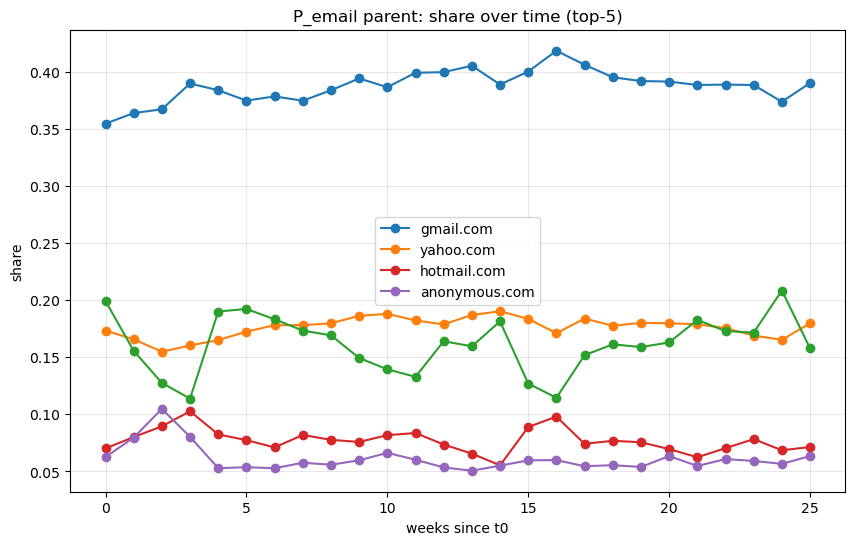

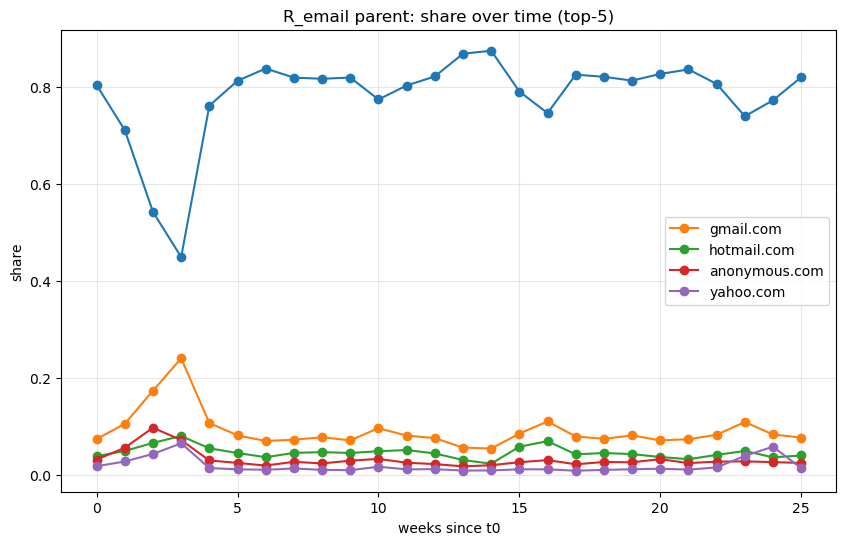

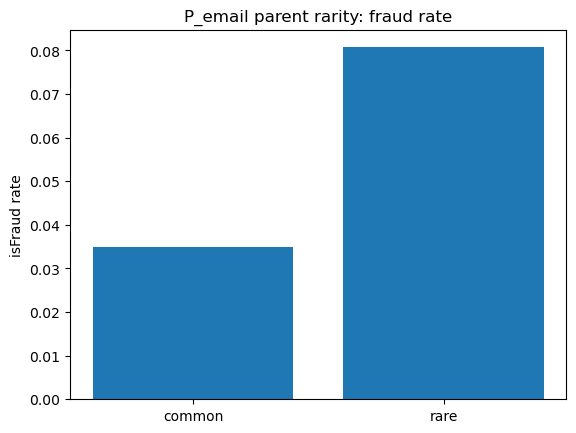

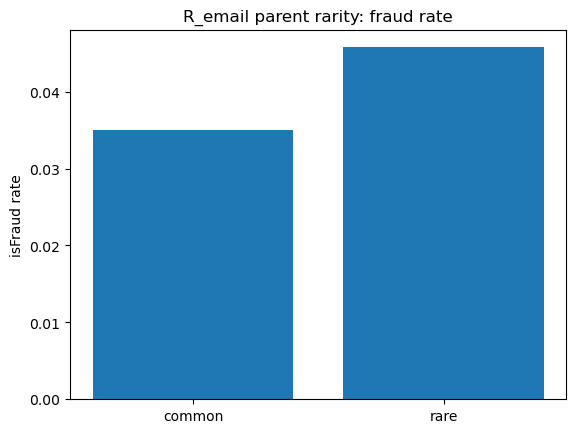

In [4]:
# 04-geo_contact_proxies
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Assumes: `tx`, TX_TRAIN exist from earlier steps ----
assert "tx" in globals() and "TX_TRAIN" in globals()

# 1) Load + merge columns
usecols_geo = ["TransactionID","addr1","addr2","dist1","dist2","P_emaildomain","R_emaildomain"]
tx_geo = pd.read_csv(TX_TRAIN, usecols=usecols_geo)
tx = tx.merge(tx_geo, on="TransactionID", how="left")

# 2) Email domain normalization helpers
DOMAIN_MAP = {
    "googlemail.com": "gmail.com",
    "hotmail.co.uk": "hotmail.com",
    "hotmail.fr": "hotmail.com",
    "hotmail.es": "hotmail.com",
    "live.com.mx": "live.com",
    "yahoo.co.jp": "yahoo.jp",
    "yahoo.co.uk": "yahoo.com",
    "yahoo.fr": "yahoo.com",
    "ymail.com": "yahoo.com",
    "outlook.com.br": "outlook.com",
    "icloud.com.cn": "icloud.com",
}

# Basic multi-part TLD handling for common cases (not exhaustive)
MULTIPART_TLDS = {
    "co.uk", "ac.uk", "gov.uk",
    "com.au", "net.au", "org.au",
    "com.br", "com.ar", "com.mx", "com.tr", "com.cn", "com.hk", "com.sg", "co.jp"
}

FREEMAIL = {
    "gmail.com","yahoo.com","yahoo.jp","hotmail.com","outlook.com","live.com","aol.com",
    "icloud.com","me.com","mac.com","msn.com","protonmail.com","gmx.com","gmx.de",
    "yandex.ru","mail.ru","rambler.ru","qq.com","163.com","126.com","sina.com","sohu.com",
    "orange.fr","free.fr","wanadoo.fr","libero.it","web.de","naver.com","daum.net","uol.com.br",
    "comcast.net","verizon.net","sbcglobal.net","att.net","bellsouth.net","cox.net"
}

def normalize_domain(x: str) -> str:
    if not isinstance(x, str): return "__NA__"
    d = x.strip().lower()
    d = DOMAIN_MAP.get(d, d)
    return d

def parent_domain(d: str) -> str:
    if d in ("__NA__", "", None): return "__NA__"
    parts = d.split(".")
    if len(parts) < 2: return d
    last2 = ".".join(parts[-2:])
    last3 = ".".join(parts[-3:])
    # if the last2 is a multi-part TLD (like co.uk), take last3; else take last2
    return last3 if last2 in MULTIPART_TLDS and len(parts) >= 3 else last2

for side in ["P", "R"]:
    col = f"{side}_emaildomain"
    tx[col] = tx[col].apply(normalize_domain)
    tx[f"{side}_ed_parent"] = tx[col].apply(parent_domain)
    tx[f"{side}_is_freemail"] = tx[f"{side}_ed_parent"].isin(FREEMAIL).astype("int8")
    tx[f"{side}_ed_is_na"] = (tx[f"{side}_ed_parent"] == "__NA__").astype("int8")

# Email match flag (same parent domain)
tx["email_parent_match"] = (tx["P_ed_parent"] == tx["R_ed_parent"]).astype("int8")

# Value counts for email domains
print("=== EMAIL DOMAIN VALUE COUNTS ===")
print("\nP_emaildomain (original) - Top 20:")
p_orig_counts = tx["P_emaildomain"].value_counts().head(20)
display(p_orig_counts)

print("\nR_emaildomain (original) - Top 20:")
r_orig_counts = tx["R_emaildomain"].value_counts().head(20)
display(r_orig_counts)

print("\nP_ed_parent (normalized) - Top 20:")
p_norm_counts = tx["P_ed_parent"].value_counts().head(20)
display(p_norm_counts)

print("\nR_ed_parent (normalized) - Top 20:")
r_norm_counts = tx["R_ed_parent"].value_counts().head(20)
display(r_norm_counts)

# Missing rates comparison
print(f"\nMissing rates:")
print(f"P_emaildomain: {tx['P_emaildomain'].isna().mean():.3f}")
print(f"R_emaildomain: {tx['R_emaildomain'].isna().mean():.3f}")
print(f"P_ed_parent: {(tx['P_ed_parent'] == '__NA__').mean():.3f}")
print(f"R_ed_parent: {(tx['R_ed_parent'] == '__NA__').mean():.3f}")

# Freemail vs Corporate distribution
print(f"\nFreemail vs Corporate:")
print(f"P_emaildomain - Freemail: {tx['P_is_freemail'].mean():.3f}")
print(f"R_emaildomain - Freemail: {tx['R_is_freemail'].mean():.3f}")
print(f"Email parent domains match: {tx['email_parent_match'].mean():.3f}")

# 3) addr*/dist* missingness flags
for c in ["addr1","addr2","dist1","dist2"]:
    tx[f"{c}_is_na"] = tx[c].isna().astype("int8")

# 4) Dist distributions (log scale) + missingness risk
for c in ["dist1","dist2"]:
    vals = tx[c].dropna().values
    if len(vals):
        fig, ax = plt.subplots()
        ax.hist(np.log1p(vals), bins=100)
        ax.set_xlabel(f"log1p({c})")
        ax.set_ylabel("count")
        ax.set_title(f"{c} distribution (log scale)")
        plt.show()

    # fraud by missingness
    fr = tx.groupby(f"{c}_is_na")["isFraud"].mean()
    fig, ax = plt.subplots()
    ax.bar(["present","missing"], [fr.get(0, np.nan), fr.get(1, np.nan)])
    ax.set_ylabel("isFraud rate")
    ax.set_title(f"{c}: fraud by missingness")
    plt.show()

# 5) addr1/addr2 top values with fraud rates
def top_levels_with_rate(df, col, topn=15):
    s = df[col].astype("Int64") if pd.api.types.is_integer_dtype(df[col]) else df[col].astype("object")
    tmp = pd.DataFrame({col: s, "target": df["isFraud"].values})
    top = (tmp.groupby(col)["target"]
             .agg(["size","mean"])
             .rename(columns={"size":"count","mean":"fraud_rate"})
             .sort_values("count", ascending=False)
             .head(topn)
             .reset_index())
    return top

addr1_top = top_levels_with_rate(tx, "addr1", topn=15)
addr2_top = top_levels_with_rate(tx, "addr2", topn=15)
print("addr1 top levels by count:")
display(addr1_top)
print("addr2 top levels by count:")
display(addr2_top)

# 6) Email domain risk views
def domain_table(df, col_parent, topn=15):
    tmp = (df.groupby(col_parent)["isFraud"]
             .agg(count="size", fraud_rate="mean")
             .sort_values("count", ascending=False)
             .head(topn)
             .reset_index())
    return tmp

p_top = domain_table(tx, "P_ed_parent", topn=15)
r_top = domain_table(tx, "R_ed_parent", topn=15)
print("P_email parent domains (top 15):")
display(p_top)
print("R_email parent domains (top 15):")
display(r_top)

# freemail vs corporate and email-parent match
summary_tbl = pd.DataFrame({
    "P_freemail_rate": [tx.loc[tx["P_is_freemail"]==1, "isFraud"].mean()],
    "P_corporate_rate": [tx.loc[tx["P_is_freemail"]==0, "isFraud"].mean()],
    "R_freemail_rate": [tx.loc[tx["R_is_freemail"]==1, "isFraud"].mean()],
    "R_corporate_rate": [tx.loc[tx["R_is_freemail"]==0, "isFraud"].mean()],
    "email_parent_match_rate": [tx.loc[tx["email_parent_match"]==1,"isFraud"].mean()],
    "email_parent_nomatch_rate": [tx.loc[tx["email_parent_match"]==0,"isFraud"].mean()],
})
print("Email-category fraud summary:")
display(summary_tbl.T.rename(columns={0:"value"}))

# 7) Time stability: share over time for top P_email parents - FIXED VERSION
def share_over_time(df, cat_col, time_col="dt_weeks", topk=5, title=None):
    top_levels = df[cat_col].value_counts().head(topk).index.tolist()
    tmp = df.copy()
    tmp["_cat"] = np.where(tmp[cat_col].isin(top_levels), tmp[cat_col], "__OTHER__")
    
    # Calculate shares using explicit merge approach (same as product analysis fix)
    time_cat_counts = tmp.groupby([time_col, "_cat"]).size().reset_index(name='count')
    time_totals = tmp.groupby(time_col).size().reset_index(name='total')
    
    # Merge and calculate shares
    merged = time_cat_counts.merge(time_totals, on=time_col)
    merged['share'] = merged['count'] / merged['total']
    
    plt.figure(figsize=(10, 6))
    for level in top_levels:
        level_data = merged[merged['_cat'] == level]
        if len(level_data) > 0:
            plt.plot(level_data[time_col], level_data['share'], 
                    label=str(level), marker='o')
    
    plt.xlabel("weeks since t0")
    plt.ylabel("share")
    plt.title(title or f"{cat_col}: share of top-{topk} over time")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

share_over_time(tx, "P_ed_parent", "dt_weeks", 5, title="P_email parent: share over time (top-5)")
share_over_time(tx, "R_ed_parent", "dt_weeks", 5, title="R_email parent: share over time (top-5)")

# 8) Rarity flags for domains (EDA-only global; model later must be time-aware)
for side in ["P","R"]:
    vc = tx[f"{side}_ed_parent"].value_counts()
    rare_levels = set(vc[vc < 100].index)  # threshold adjustable
    tx[f"{side}_ed_is_rare"] = tx[f"{side}_ed_parent"].isin(rare_levels).astype("int8")
    fr = tx.groupby(f"{side}_ed_is_rare")["isFraud"].mean()
    fig, ax = plt.subplots()
    ax.bar(["common","rare"], [fr.get(0, np.nan), fr.get(1, np.nan)])
    ax.set_ylabel("isFraud rate")
    ax.set_title(f"{side}_email parent rarity: fraud rate")
    plt.show()

# Category 5A: Behavioral Aggregates — C*, D*, M* (lightweight, no V* yet)

This loads C/D/M, builds missingness signatures, checks time-drift (esp. D*), and surfaces top features by simple correlation with the label. We’ll handle V* in a separate step.

- D & M missingness drift is real; D13/D6/D14 show sharp time spikes → treat D* with extra care in time-based CV.
- M_bin features* (“T/F” style) correlate negatively with fraud (T ≈ safer).
- Family missingness vs fraud isn’t monotonic for all families → keep the raw na_ratio_* features (and maybe bins), don’t force monotone assumptions.

Family missingness overview:


,family,n_cols,mean_na_ratio
0,C,14,0.000000
1,D,15,0.581513
2,M,9,0.499233


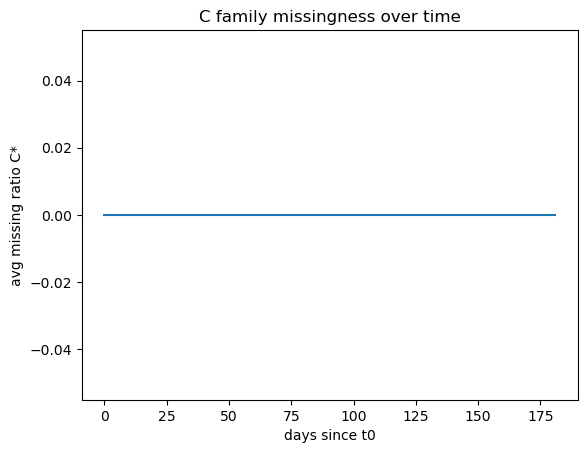

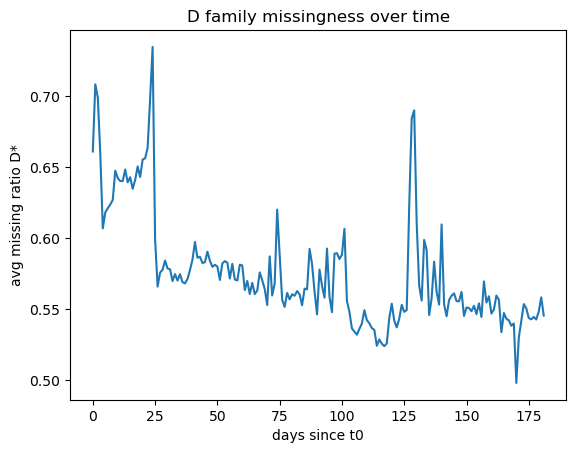

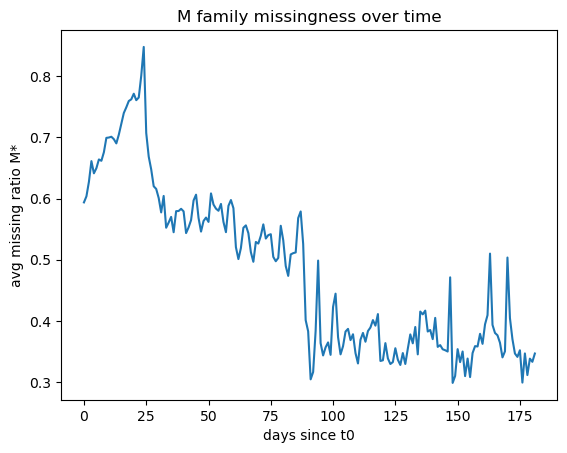


[M1] top-5 values by count:


,M1,count,fraud_rate
0,T,319415.0,0.019855
1,NaN,NaN,NaN
2,F,25.0,0.000000



[M2] top-5 values by count:


,M2,count,fraud_rate
0,T,285468.0,0.018069
1,NaN,NaN,NaN
2,F,33972.0,0.034852



[M3] top-5 values by count:


,M3,count,fraud_rate
0,NaN,NaN,NaN
1,T,251731.0,0.017054
2,F,67709.0,0.030262



[M4] top-5 values by count:


,M4,count,fraud_rate
0,NaN,NaN,NaN
1,M0,196405.0,0.036649
2,M2,59865.0,0.113739
3,M1,52826.0,0.027051



[M5] top-5 values by count:


,M5,count,fraud_rate
0,NaN,NaN,NaN
1,F,132491.0,0.026523
2,T,107567.0,0.037697



[M6] top-5 values by count:


,M6,count,fraud_rate
0,F,227856.0,0.023686
1,T,193324.0,0.017044
2,NaN,NaN,NaN



[M7] top-5 values by count:


,M7,count,fraud_rate
0,NaN,NaN,NaN
1,F,211374.0,0.019345
2,T,32901.0,0.022127



[M8] top-5 values by count:


,M8,count,fraud_rate
0,NaN,NaN,NaN
1,F,155251.0,0.021726
2,T,89037.0,0.016218



[M9] top-5 values by count:


,M9,count,fraud_rate
0,NaN,NaN,NaN
1,T,205656.0,0.017787
2,F,38632.0,0.030001



Top 15 numeric C/D/M features by |corr| with isFraud:


,feature,pearson_corr_with_label
0,M1_bin,-0.089400
1,M2_bin,-0.089079
2,M3_bin,-0.084136
3,D15,-0.073826
4,D10,-0.070583
5,M9_bin,-0.068434
6,M6_bin,-0.068134
7,D9,-0.067903
8,D1,-0.067103
9,D2,-0.064764



Top 10 D* by |Spearman corr| with time (drift candidates):


,feature,spearman_corr_with_time
0,D13,0.122841
1,D6,0.114563
2,D14,0.105751
3,D11,0.100237
4,D1,0.098193
5,D12,0.072246
6,D8,-0.071704
7,D15,0.065169
8,D4,0.053316
9,D10,0.048056


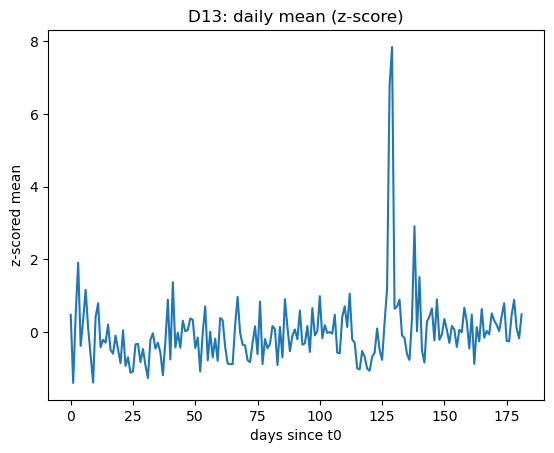

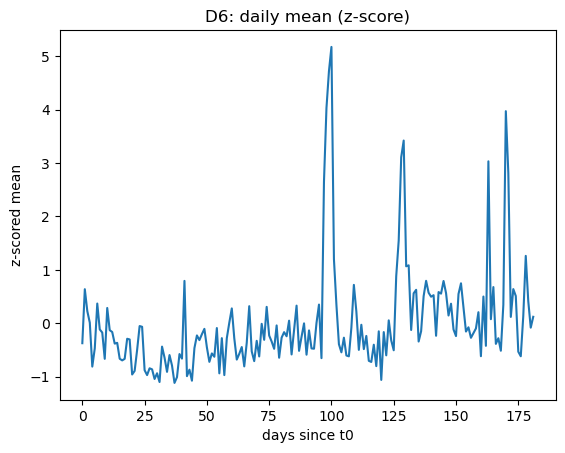

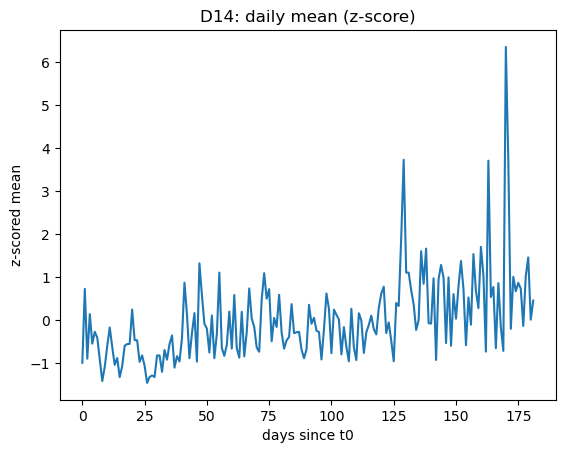

/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_10243/776102181.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fr = tx.groupby(q)["isFraud"].mean()


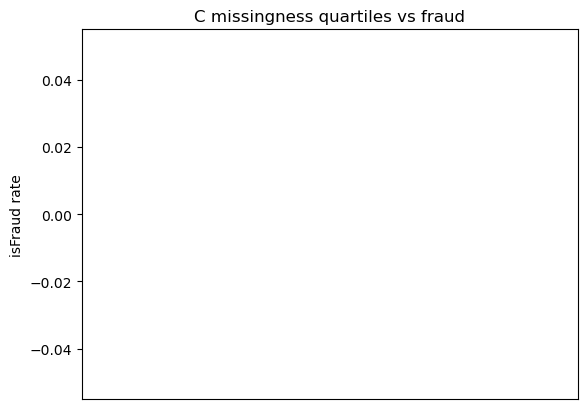

/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_10243/776102181.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fr = tx.groupby(q)["isFraud"].mean()


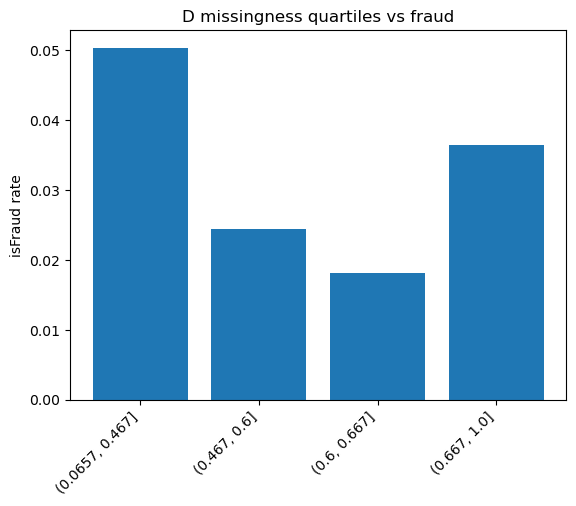

/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_10243/776102181.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fr = tx.groupby(q)["isFraud"].mean()


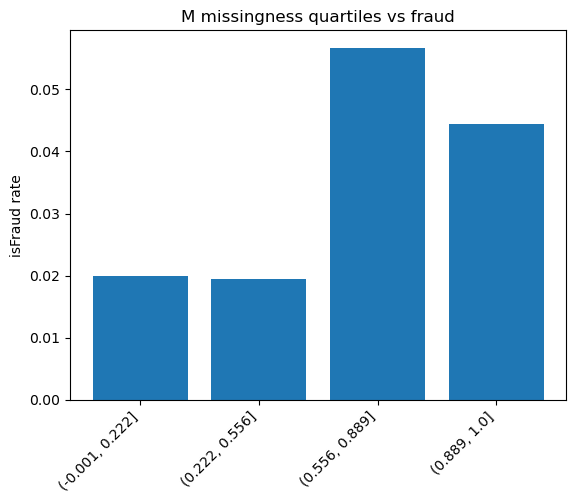

In [5]:
# 05A-behavioral_aggregates_CDM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "tx" in globals() and "TX_TRAIN" in globals(), "Run earlier cells first."

# -------- 1) discover column names & load only C/D/M (dtype-aware) --------
cols_all = pd.read_csv(TX_TRAIN, nrows=0).columns.tolist()
C_cols = [c for c in cols_all if c.startswith("C")]
D_cols = [c for c in cols_all if c.startswith("D")]
M_cols = [c for c in cols_all if c.startswith("M")]

usecols = ["TransactionID"] + C_cols + D_cols + M_cols
dtypes = {**{c: "float32" for c in C_cols + D_cols}}  # M* left as object
cdm = pd.read_csv(TX_TRAIN, usecols=usecols, dtype=dtypes, low_memory=False)

# Merge
tx = tx.merge(cdm, on="TransactionID", how="left")

# -------- 2) family-level missingness signatures --------
def family_missing_stats(df, cols, family):
    if not cols: 
        return pd.Series(dtype="float32")
    miss_ratio = df[cols].isna().mean(axis=1).astype("float32")
    df[f"na_ratio_{family}"] = miss_ratio
    df[f"na_ct_{family}"] = df[cols].isna().sum(axis=1).astype("int16")
    return miss_ratio

miss_C = family_missing_stats(tx, C_cols, "C")
miss_D = family_missing_stats(tx, D_cols, "D")
miss_M = family_missing_stats(tx, M_cols, "M")

fam_missing_overview = pd.DataFrame({
    "family": ["C","D","M"],
    "n_cols": [len(C_cols), len(D_cols), len(M_cols)],
    "mean_na_ratio": [
        float(miss_C.mean()) if len(C_cols) else np.nan,
        float(miss_D.mean()) if len(D_cols) else np.nan,
        float(miss_M.mean()) if len(M_cols) else np.nan,
    ],
})
print("Family missingness overview:")
display(fam_missing_overview)

# Missingness by time (average per day)
for fam in ["C","D","M"]:
    col = f"na_ratio_{fam}"
    if col in tx.columns:
        series = tx.groupby("dt_days")[col].mean().reset_index()
        fig, ax = plt.subplots()
        ax.plot(series["dt_days"], series[col])
        ax.set_xlabel("days since t0")
        ax.set_ylabel(f"avg missing ratio {fam}*")
        ax.set_title(f"{fam} family missingness over time")
        plt.show()

# -------- 3) M* columns: value profiles & fraud rates --------
def summarize_M(df, mcol, topn=5):
    vc = df[mcol].value_counts(dropna=False).head(topn)
    tab = (df.groupby(mcol)["isFraud"]
             .agg(count="size", fraud_rate="mean")
             .reindex(vc.index)
             .reset_index())
    tab.columns = [mcol, "count", "fraud_rate"]
    print(f"\n[{mcol}] top-{topn} values by count:")
    display(tab)

for mcol in (M_cols[:10] if len(M_cols) > 10 else M_cols):
    summarize_M(tx, mcol, topn=5)

# Optional: crude booleanization for M-like T/F values (creates new *_bin cols)
def booleanize_M_column(s):
    # Map common tokens to {0,1}, leave others as NaN (e.g., 'M0' stays NaN)
    if s.dtype.name == "category":
        s = s.astype("object")
    s2 = s.astype("string").str.strip().str.lower()
    return (s2.isin(["t","true","1"])).astype("float32") * 1.0 + \
           (s2.isin(["f","false","0"])).astype("float32") * 0.0

for mcol in M_cols:
    try:
        tx[mcol + "_bin"] = booleanize_M_column(tx[mcol])
    except Exception:
        pass

# -------- 4) simple label correlations (numeric only) --------
# We'll compute Pearson corr between numeric features and isFraud (binary 0/1).
y = tx["isFraud"].astype("float32").values

num_cols = []
for c in C_cols + D_cols:
    if c in tx.columns and np.issubdtype(tx[c].dtype, np.number):
        num_cols.append(c)
for mcol in [c for c in tx.columns if c.endswith("_bin")]:
    num_cols.append(mcol)

def safe_corr(x, y):
    x = pd.Series(x)
    if x.isna().all():
        return np.nan
    xc = x.fillna(x.median())
    if xc.std(ddof=0) == 0:
        return 0.0
    return float(np.corrcoef(xc, y)[0,1])

corrs = [(c, safe_corr(tx[c].values, y)) for c in num_cols]
corrs_sorted = sorted([t for t in corrs if not np.isnan(t[1])], key=lambda t: abs(t[1]), reverse=True)
print("\nTop 15 numeric C/D/M features by |corr| with isFraud:")
display(pd.DataFrame(corrs_sorted[:15], columns=["feature","pearson_corr_with_label"]))

# -------- 5) D* time-drift scan --------
# Spearman correlation of each D* with time (dt_days)
def safe_spearman(x, t):
    x = pd.Series(x)
    if x.isna().all():
        return np.nan
    return float(x.corr(pd.Series(t), method="spearman"))

t_days = tx["dt_days"].astype("int32").values
D_corr_time = []
for c in D_cols:
    if c in tx.columns and np.issubdtype(tx[c].dtype, np.number):
        try:
            D_corr_time.append((c, safe_spearman(tx[c].values, t_days)))
        except Exception:
            pass
D_corr_time = sorted([t for t in D_corr_time if not np.isnan(t[1])], key=lambda t: abs(t[1]), reverse=True)
print("\nTop 10 D* by |Spearman corr| with time (drift candidates):")
display(pd.DataFrame(D_corr_time[:10], columns=["feature","spearman_corr_with_time"]))

# Plot daily standardized means for the top-3 drift candidates
top_drift = [f for f,_ in D_corr_time[:3]]
for c in top_drift:
    byday = tx.groupby("dt_days")[c].mean()
    z = (byday - byday.mean()) / (byday.std(ddof=0) + 1e-9)
    fig, ax = plt.subplots()
    ax.plot(byday.index, z.values)
    ax.set_xlabel("days since t0")
    ax.set_ylabel("z-scored mean")
    ax.set_title(f"{c}: daily mean (z-score)")
    plt.show()

# -------- 6) Family-level missingness vs fraud (bin by quartiles) --------
for fam in ["C","D","M"]:
    col = f"na_ratio_{fam}"
    if col in tx.columns:
        q = pd.qcut(tx[col], q=4, duplicates="drop")
        fr = tx.groupby(q)["isFraud"].mean()
        fig, ax = plt.subplots()
        ax.bar(range(len(fr)), fr.values)
        ax.set_xticks(range(len(fr)))
        ax.set_xticklabels([str(i) for i in fr.index.astype(str)], rotation=45, ha="right")
        ax.set_ylabel("isFraud rate")
        ax.set_title(f"{fam} missingness quartiles vs fraud")
        plt.show()

# Category 5B — V* block (V1–V339)

Memory-safe pass over V*: column missingness, label correlation, time drift, and a row-level na_ratio_V.
(Change BLOCK if you hit RAM limits.)

What the V-block is telling us
- Coverage & drift: 339 V cols with mean missingness ≈ 0.43. Early regime shift (≈ day 20–30) and later spikes (~130 & ~165). That’s classic distribution drift → validate strictly over time.
- Missingness signal: Lowest-missingness quartile has the highest fraud (~4.0% vs ~2.3–2.5%). Keep both na_ct_V and na_ratio_V (and consider simple bins) as robust signals.
- Hot V clusters: V242–V258, V200–V201, V44–V45, V86–V87 rank highest by |corr|. Lots of near-duplicates inside those clusters—fine for trees; we’ll consider pruning for speed during feature selection (inside folds).
- Drift watchlist: V10, V11 trend up; V302 trends down with a big early spike. Don’t drop them pre-emptively, but rely on chronological CV so any time-local advantage doesn’t leak.

# of V* columns: 339
Processed V cols 1..40 / 339
Processed V cols 41..80 / 339
Processed V cols 81..120 / 339
Processed V cols 121..160 / 339
Processed V cols 161..200 / 339
Processed V cols 201..240 / 339
Processed V cols 241..280 / 339
Processed V cols 281..320 / 339
Processed V cols 321..339 / 339

V family overview:


,value
n_cols,339.000000
mean_na_ratio,0.430385



Top 20 V* by |corr| with label:


,feature,pearson_corr_with_label
256,V257,0.280214
245,V246,0.268090
243,V244,0.265712
241,V242,0.263476
200,V201,0.246462
199,V200,0.238290
44,V45,0.235436
188,V189,0.225829
85,V86,0.222343
86,V87,0.221568



Top 10 V* drift candidates by |Spearman(time)|:


,feature,spearman_corr_with_time
10,V11,0.177261
9,V10,0.176159
301,V302,-0.144595
303,V304,-0.142727
150,V151,-0.142011
302,V303,-0.141344
149,V150,-0.136005
158,V159,-0.126085
142,V143,-0.118392
163,V164,-0.118296


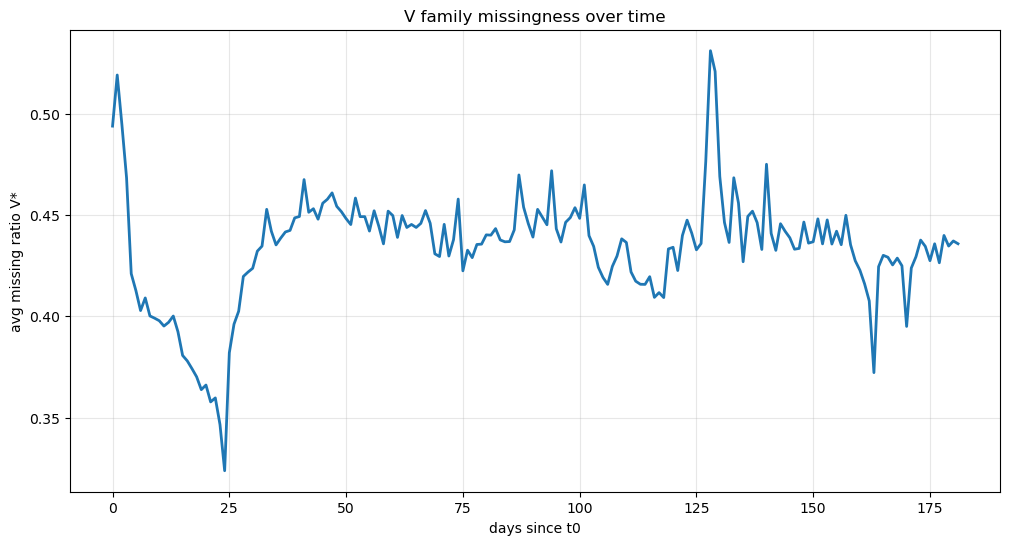

/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_10243/256606613.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fr = tx.groupby(q)["isFraud"].mean()


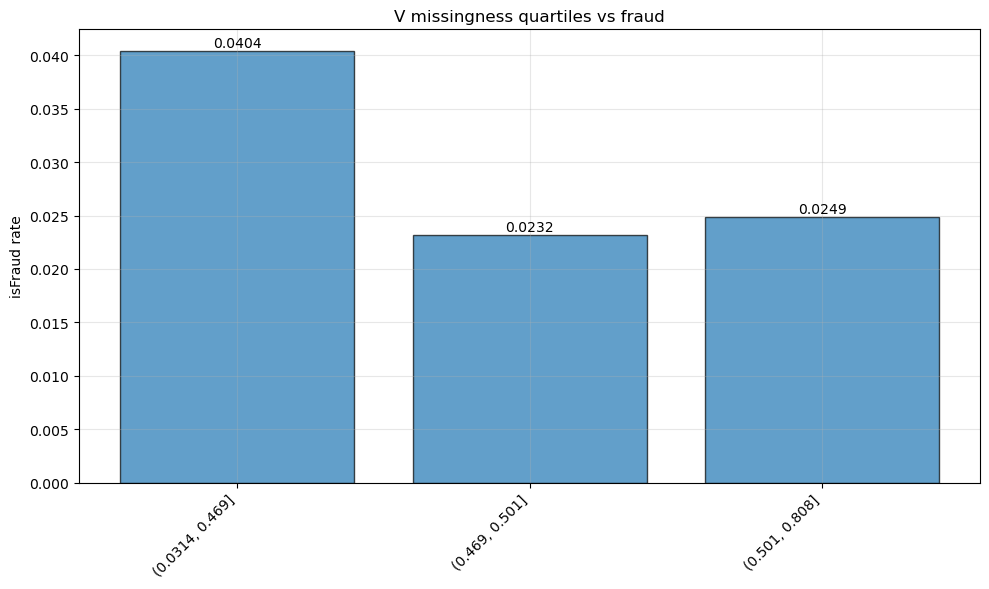

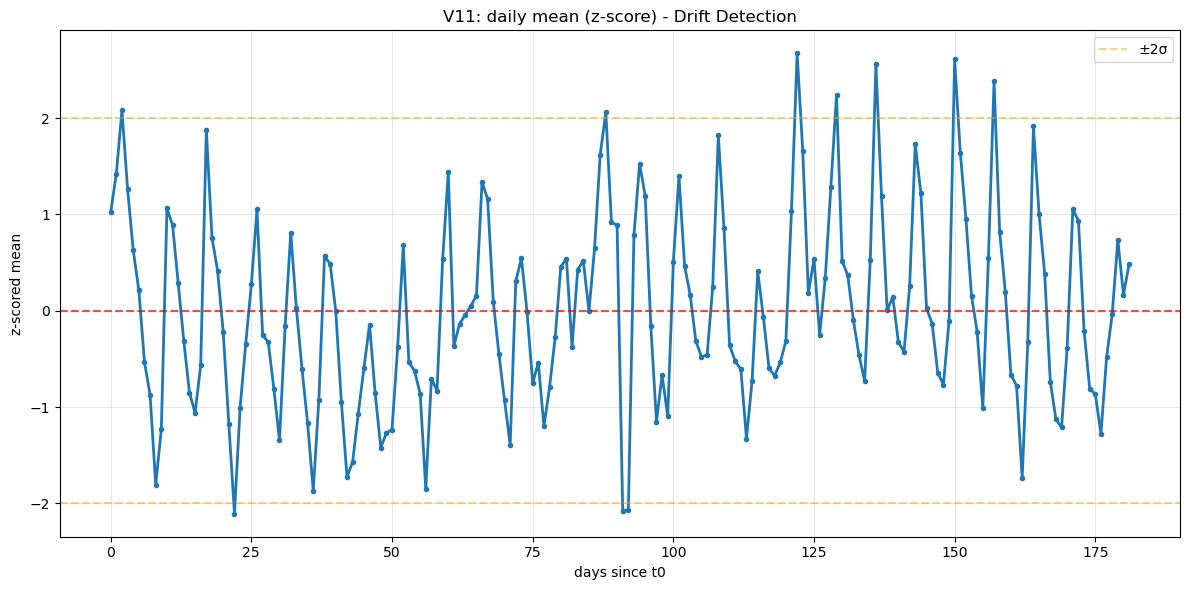

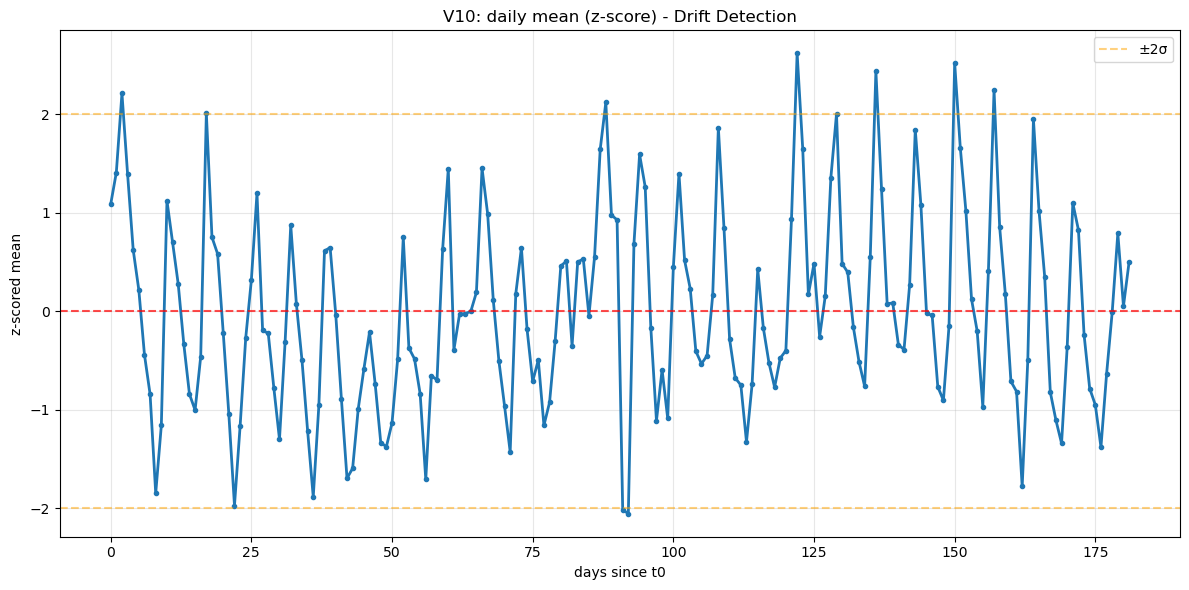

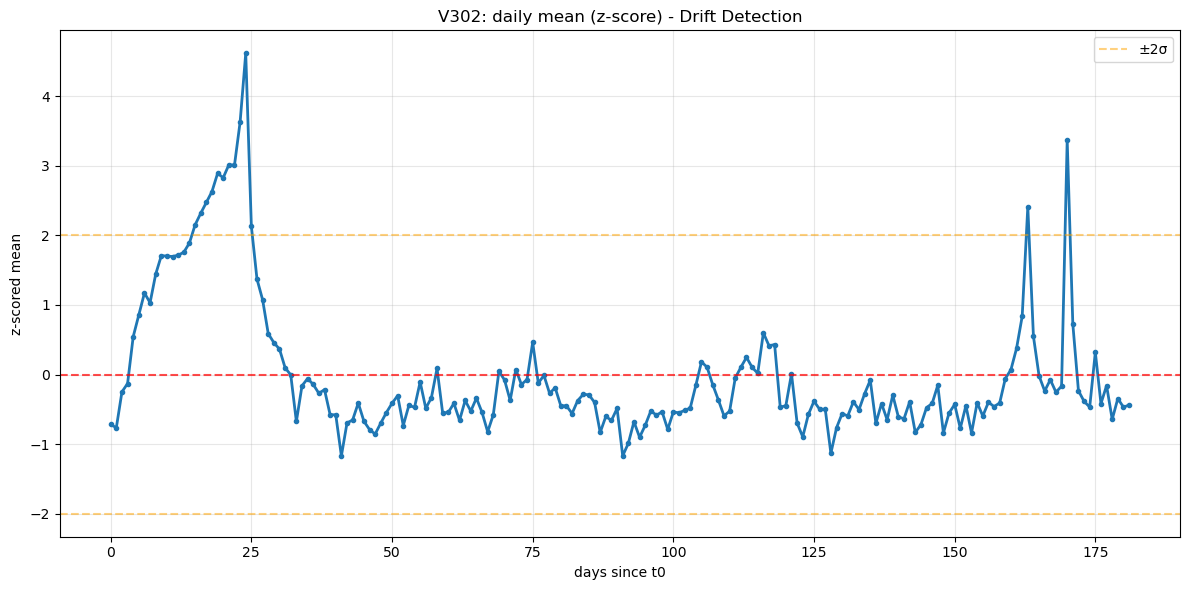

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "tx" in globals() and "TX_TRAIN" in globals(), "Run earlier cells first."

# 1) Discover V columns
cols_all = pd.read_csv(TX_TRAIN, nrows=0).columns.tolist()
V_cols = [c for c in cols_all if c.startswith("V")]
print(f"# of V* columns: {len(V_cols)}")

# Base info for joins / alignment
base = tx[["TransactionID", "isFraud", "dt_days"]].reset_index(drop=True)
row_indexer = pd.Series(base.index.values, index=base["TransactionID"].values)

# Accumulators
v_na_counts = np.zeros(len(base), dtype=np.int32)  # per-row NA count across all V*
col_missing = {}
col_corr_label = {}
col_spear_time = {}

def safe_corr_num(x: pd.Series, y: np.ndarray) -> float:
    if x.notna().sum() == 0:
        return np.nan
    xv = x.fillna(x.median())
    sd = float(xv.std(ddof=0))
    if sd == 0.0:
        return 0.0
    return float(np.corrcoef(xv.values, y)[0, 1])

# 2) Chunked scan over V* to control memory
BLOCK = 40
for i in range(0, len(V_cols), BLOCK):
    cols = V_cols[i:i+BLOCK]
    use = ["TransactionID"] + cols
    vpart = pd.read_csv(TX_TRAIN, usecols=use, dtype={c: "float32" for c in cols}, low_memory=False)

    # Row-wise NA accumulation for V*
    na_ct = vpart[cols].isna().sum(axis=1).astype("int32").values
    pos = row_indexer.loc[vpart["TransactionID"]].values
    v_na_counts[pos] += na_ct

    # Merge minimal label/time for per-column stats
    vpart = vpart.merge(base, on="TransactionID", how="left")
    y = vpart["isFraud"].astype("float32").values
    t_days = vpart["dt_days"].astype("int32")

    # Column stats
    for c in cols:
        s = vpart[c]
        col_missing[c] = float(s.isna().mean())
        col_corr_label[c] = safe_corr_num(s, y)
        # Spearman with time for drift
        col_spear_time[c] = float(s.fillna(s.median()).corr(t_days, method="spearman"))

    print(f"Processed V cols {i+1}..{i+len(cols)} / {len(V_cols)}")

# 3) Attach row-level V missingness to tx
total_V = len(V_cols)
base["na_ct_V"] = v_na_counts.astype("int32")
base["na_ratio_V"] = base["na_ct_V"] / float(total_V)
tx = tx.merge(base[["TransactionID", "na_ct_V", "na_ratio_V"]], on="TransactionID", how="left")

# 4) Overview + top features
print("\nV family overview:")
overview = pd.DataFrame({
    "n_cols": [total_V],
    "mean_na_ratio": [float(base["na_ratio_V"].mean())],
})
display(overview.T.rename(columns={0: "value"}))

corr_df = (pd.DataFrame({
    "feature": list(col_corr_label.keys()),
    "pearson_corr_with_label": list(col_corr_label.values())
})
.assign(abs_corr=lambda d: d["pearson_corr_with_label"].abs())
.sort_values("abs_corr", ascending=False)
.head(20)
.drop(columns="abs_corr"))
print("\nTop 20 V* by |corr| with label:")
display(corr_df)

time_df = (pd.DataFrame({
    "feature": list(col_spear_time.keys()),
    "spearman_corr_with_time": list(col_spear_time.values())
})
.assign(abs_corr=lambda d: d["spearman_corr_with_time"].abs())
.sort_values("abs_corr", ascending=False)
.head(10)
.drop(columns="abs_corr"))
print("\nTop 10 V* drift candidates by |Spearman(time)|:")
display(time_df)

# 5) V-family missingness over time
v_miss_by_day = tx.groupby("dt_days")["na_ratio_V"].mean().reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(v_miss_by_day["dt_days"], v_miss_by_day["na_ratio_V"], linewidth=2)
ax.set_xlabel("days since t0")
ax.set_ylabel("avg missing ratio V*")
ax.set_title("V family missingness over time")
ax.grid(True, alpha=0.3)
plt.show()

# 6) V missingness quartiles vs fraud
q = pd.qcut(tx["na_ratio_V"], q=4, duplicates="drop")
fr = tx.groupby(q)["isFraud"].mean()
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(fr)), fr.values, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(fr)))
ax.set_xticklabels([str(i) for i in fr.index.astype(str)], rotation=45, ha="right")
ax.set_ylabel("isFraud rate")
ax.set_title("V missingness quartiles vs fraud")
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
            f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 7) Daily z-mean for top-3 drift V* features
top3 = time_df["feature"].head(3).tolist()
for c in top3:
    vcol = pd.read_csv(TX_TRAIN, usecols=["TransactionID", c], dtype={c: "float32"})
    vcol = vcol.merge(tx[["TransactionID", "dt_days"]], on="TransactionID", how="left")
    byday = vcol.groupby("dt_days")[c].mean()
    z = (byday - byday.mean()) / (byday.std(ddof=0) + 1e-9)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(byday.index, z.values, linewidth=2, marker='o', markersize=3)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax.axhline(y=2, color='orange', linestyle='--', alpha=0.5, label='±2σ')
    ax.axhline(y=-2, color='orange', linestyle='--', alpha=0.5)
    ax.set_xlabel("days since t0")
    ax.set_ylabel("z-scored mean")
    ax.set_title(f"{c}: daily mean (z-score) - Drift Detection")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Category 6: Device & Identity Footprint

This adds/normalizes identity columns, builds missingness signatures, and plots stability + risk for OS/browser/brand/resolution. (No PCA/corr pruning here.)

What the plots/tables say
- Join coverage is low & not random: only 24.4% of transactions have an identity row. Fraud rate jumps from 2.09% (no identity) → 7.85% (has identity) — ~3.8×. Missing identity is itself a signal; treat it explicitly, not as “missing at random.”
- OS share is dominated by Windows after week ~4 (≈90%+). The first few weeks show a transient mobile+iOS/Android blip; that’s a time regime change → reinforces time-based CV.
- Browser mix follows Chrome (≈80%+ most weeks). Safari is the second cluster; Opera/other have very high fraud rates (Opera ≈ 31.6%) but tiny counts → keep but bucket as “rare.”
- DeviceType risks differ: mobile ≈ 10.2%, desktop ≈ 6.5%. Even desktop is well above the global 3.5% because identity-present rows are riskier overall.
- Brand effects: among rows with DeviceInfo, samsung (11.6%) / huawei (13.4%) / motorola (15.2%) run hotter; apple (2.2%) is cooler. Note that na is huge (identity missing) and sits near base (2.55%) → “brand missing” is basically “no identity.”
- Resolution buckets: very small widths (≤720, 721–1080) show high rates but tiny n; treat via rarity buckets to avoid overfitting.

Shapes: {'transactions': 590540, 'identity_rows': 144233, 'join_hit_rate': 0.2442391709283029}

Typed columns:
  CONT: 11 → ['id_01', 'id_02', 'id_03', 'id_04', 'id_05'] ...
  CAT : 29 → ['id_12', 'id_13', 'id_14', 'id_15', 'id_16'] ...

Fraud rate: identity present vs missing
is_identity_present
missing    0.020939
present    0.078470
Name: isFraud, dtype: float64

Missingness (ID_CONT vs ID_CAT)
{'mean_na_ratio_CONT': 0.8471933238299614, 'mean_na_ratio_CAT': 0.8439423648490045}

[id_30_os]
    id_30_os   count  fraud_rate
0     __na__  512975    0.033571
1    windows   36739    0.034514
2        ios   19782    0.062683
3      macos   13580    0.021944
4    android    6303    0.085991
5      linux    1136    0.074824
6  __other__      25    0.360000

[id_31_br]
    id_31_br   count  fraud_rate
0     __na__  450258    0.021081
1     chrome   76059    0.095952
2     safari   37281    0.063947
3         ie   10018    0.025454
4    firefox    7017    0.078809
5       edge    6401    0.035

/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_10243/1909623777.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (df.groupby(col)["isFraud"]


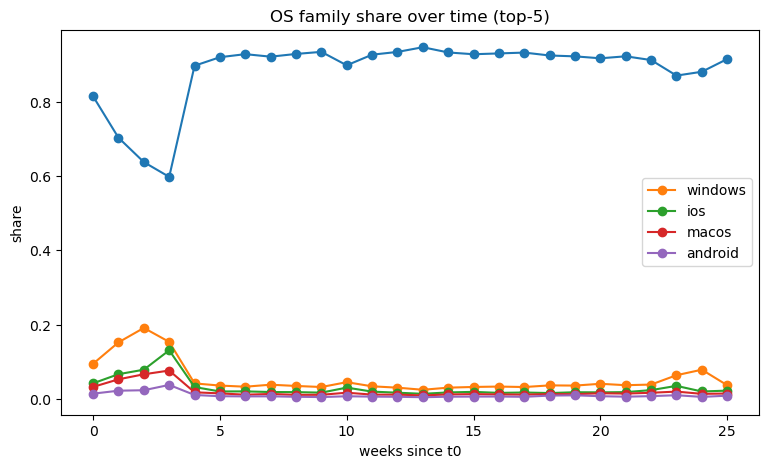

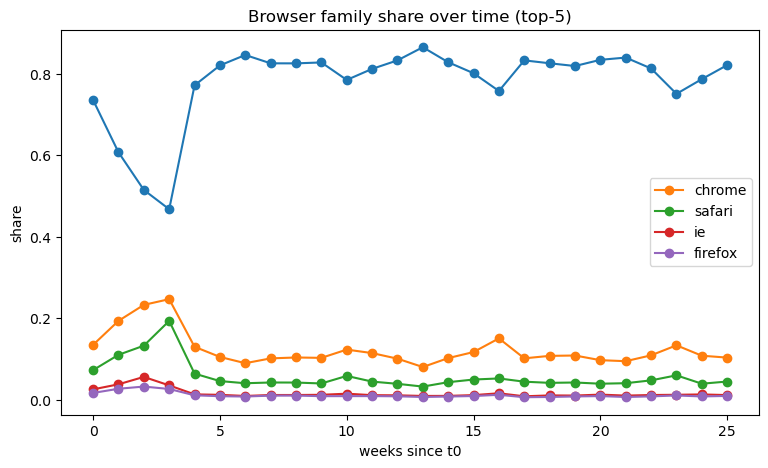

/var/folders/hb/60c6m96123sbxhdf8p4mnz6c0000gn/T/ipykernel_10243/1909623777.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fr = df.groupby(q)["isFraud"].mean()


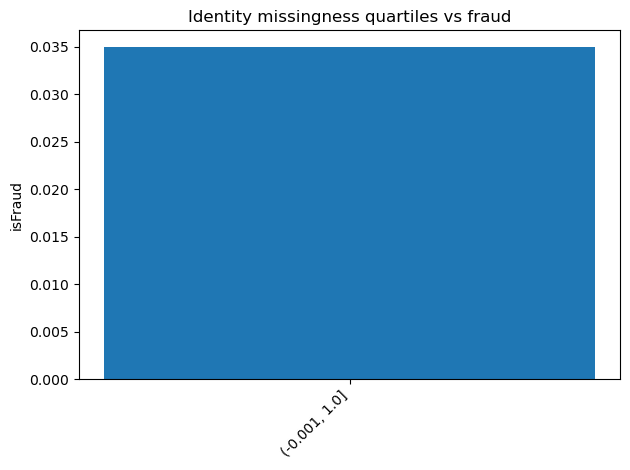

In [28]:
# 06_identity_device_from_raw

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAW_DIR = Path("../data/raw")
TX_TRAIN = RAW_DIR / "train_transaction.csv"
ID_TRAIN = RAW_DIR / "train_identity.csv"

# 0) Load transaction minimally (for time + label)
use_tx = ["TransactionID", "TransactionDT", "isFraud"]
tx = pd.read_csv(TX_TRAIN, usecols=use_tx, dtype={"TransactionID":"int64","TransactionDT":"int32","isFraud":"int8"})
t0 = tx["TransactionDT"].min()
tx["dt_days"]  = ((tx["TransactionDT"] - t0) / 86400.0).astype("float32")
tx["dt_weeks"] = (tx["dt_days"] // 7).astype("int16")

# 1) Identity types (as requested)
ID_CONT = [f"id_{i:02d}" for i in range(1, 12)]                              # continuous
ID_CAT  = [f"id_{i:02d}" for i in range(12, 39)] + ["DeviceType", "DeviceInfo"]  # categorical

dtype_id = {**{c: "float32" for c in ID_CONT}, **{c: "object" for c in ID_CAT}}
use_id   = ["TransactionID"] + ID_CONT + ID_CAT
id_df = pd.read_csv(ID_TRAIN, usecols=use_id, dtype=dtype_id, low_memory=False)

# 2) Merge & basic signals
df = tx.merge(id_df, on="TransactionID", how="left", validate="one_to_one")
df["is_identity_present"] = (~df[ID_CONT + ID_CAT].isna()).any(axis=1).astype("int8")
df["na_ct_id"]   = df[ID_CONT + ID_CAT].isna().sum(axis=1).astype("int16")
df["na_ratio_id"] = (df["na_ct_id"] / (len(ID_CONT)+len(ID_CAT))).astype("float32")

print("Shapes:", {"transactions": len(tx), "identity_rows": id_df["TransactionID"].nunique(),
                  "join_hit_rate": df["is_identity_present"].mean()})

# 3) Normalizers (lightweight, for EDA only)
def os_family(x):
    s = x.lower() if isinstance(x,str) else ""
    if "windows" in s: return "windows"
    if "android" in s: return "android"
    if "ios" in s: return "ios"
    if "mac os" in s or s.startswith("mac"): return "macos"
    if "linux" in s: return "linux"
    return "__other__" if s else "__na__"

def browser_family(x):
    s = x.lower() if isinstance(x,str) else ""
    if "chrome" in s or "crios" in s: return "chrome"
    if "safari" in s and "chrome" not in s: return "safari"
    if "firefox" in s: return "firefox"
    if "edge" in s: return "edge"
    if any(t in s for t in ["ie","internet explorer","trident"]): return "ie"
    if "samsung" in s: return "samsung"
    if "opera" in s or "opr" in s: return "opera"
    if "android webview" in s or s.strip()=="wv": return "android_webview"
    return "__other__" if s else "__na__"

BRAND_MAP = {
    "samsung":"samsung","sm-":"samsung","gt-":"samsung","galaxy":"samsung",
    "apple":"apple","iphone":"apple","ipad":"apple","mac":"apple",
    "huawei":"huawei","honor":"huawei","moto":"motorola","motorola":"motorola",
    "lg-":"lg","lg ":"lg","lenovo":"lenovo","asus":"asus","oneplus":"oneplus",
    "xiaomi":"xiaomi","redmi":"xiaomi","mi ":"xiaomi","oppo":"oppo","vivo":"vivo",
    "google":"google","pixel":"google","nexus":"google","nokia":"nokia","sony":"sony",
    "htc":"htc","zte":"zte","alcatel":"alcatel"
}
def device_brand(x):
    if not isinstance(x,str): return "__na__"
    s = x.lower()
    for k,v in BRAND_MAP.items():
        if k in s: return v
    if any(t in s for t in ["windows","linux"]): return "pc_generic"
    return "__other__"

def parse_res(x):
    if not isinstance(x,str): return pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan], index=["scr_w","scr_h","aspect","is_portrait","is_hd"])
    m = re.match(r"(\d{2,5})x(\d{2,5})", x.strip().lower())
    if not m: return pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan], index=["scr_w","scr_h","aspect","is_portrait","is_hd"])
    w, h = int(m.group(1)), int(m.group(2))
    return pd.Series([w, h, round(w/h,2) if h else np.nan, int(h>w), int(w>=1280)], index=["scr_w","scr_h","aspect","is_portrait","is_hd"])

df["id_30_os"] = df["id_30"].apply(os_family)       # OS
df["id_31_br"] = df["id_31"].apply(browser_family)  # Browser
res_feats = df["id_33"].apply(parse_res)
df = pd.concat([df, res_feats], axis=1)
df["DeviceBrand"] = df["DeviceInfo"].apply(device_brand)

# 4) Quick typing report
print("\nTyped columns:")
print("  CONT:", len(ID_CONT), "→", ID_CONT[:5], "...")
print("  CAT :", len(ID_CAT),  "→", ID_CAT[:5],  "...")

# 5) Core identity summaries
def top_table(col, topn=15):
    out = (df.groupby(col)["isFraud"]
             .agg(count="size", fraud_rate="mean")
             .sort_values("count", ascending=False)
             .head(topn).reset_index())
    return out

print("\nFraud rate: identity present vs missing")
print(df.groupby("is_identity_present")["isFraud"].mean().rename({0:"missing",1:"present"}))

print("\nMissingness (ID_CONT vs ID_CAT)")
miss_cont = df[ID_CONT].isna().mean(axis=1).mean()
miss_cat  = df[ID_CAT].isna().mean(axis=1).mean()
print({"mean_na_ratio_CONT": float(miss_cont), "mean_na_ratio_CAT": float(miss_cat)})

# 6) Risk tables
tab_os  = top_table("id_30_os", 10);       print("\n[id_30_os]");  print(tab_os)
tab_br  = top_table("id_31_br", 10);       print("\n[id_31_br]");  print(tab_br)
tab_dev = top_table("DeviceType", 10);     print("\n[DeviceType]");print(tab_dev)
tab_brand = top_table("DeviceBrand", 10);  print("\n[DeviceBrand]");print(tab_brand)

# Resolution bucket (by width)
df["res_bucket"] = pd.cut(df["scr_w"], bins=[-np.inf, 720, 1080, 1440, 1920, np.inf],
                          labels=["<=720","721-1080","1081-1440","1441-1920",">1920"])
tab_res = top_table("res_bucket", 10);     print("\n[res_bucket]"); print(tab_res)

# 7) Time stability — shares over weeks
def share_over_time(cat_col, title, topk=5):
    top_levels = df[cat_col].value_counts().head(topk).index.tolist()
    tmp = df.assign(_cat=lambda d: np.where(d[cat_col].isin(top_levels), d[cat_col], "__OTHER__"))
    g = (tmp.groupby(["dt_weeks","_cat"]).size().reset_index(name="n")
           .merge(df.groupby("dt_weeks").size().reset_index(name="tot"), on="dt_weeks"))
    g["share"] = g["n"] / g["tot"]
    plt.figure(figsize=(9,5))
    for lvl in top_levels:
        sub = g[g["_cat"]==lvl]
        plt.plot(sub["dt_weeks"], sub["share"], marker="o", label=str(lvl))
    plt.xlabel("weeks since t0"); plt.ylabel("share"); plt.title(title); plt.legend(); plt.show()

share_over_time("id_30_os", "OS family share over time (top-5)")
share_over_time("id_31_br", "Browser family share over time (top-5)")

# 8) Identity missingness vs fraud (quartiles)
q = pd.qcut(df["na_ratio_id"], q=4, duplicates="drop")
fr = df.groupby(q)["isFraud"].mean()
plt.figure()
plt.bar(range(len(fr)), fr.values)
plt.xticks(range(len(fr)), [str(i) for i in fr.index.astype(str)], rotation=45, ha="right")
plt.ylabel("isFraud"); plt.title("Identity missingness quartiles vs fraud"); plt.tight_layout(); plt.show()

# 9) (Optional) quick look at categorical id_* columns one by one (top K)
# Warning: many columns → uncomment selectively
# for c in ["id_12","id_13","id_14","id_15","id_16","id_19","id_20","id_28","id_29","id_34","id_35","id_36","id_37","id_38"]:
#     print(f"\n[{c}] top-10"); print(top_table(c, 10))